# Loan Default Prediction

Author: Won Seo

## Summary

The model can be used to predict whether a future customer will default a loan, given the information we have primarily from the FICO table. The default prediction will help the company decide whether to invest a loan and develop an automatic loan approval system.

## Contents

[__Step 1: Data Preprocessing__](#Step1)

[1.1 Import data](#1.1)
- [1.1.1 Concatenate CURO dataframes](#1.1.1)
- [1.1.2 Merge CURO & FICO tables](#1.1.2)

[1.2 Convert data types](#1.2)

[1.3 Deal with categorical variables: labeling & missing value handling](#1.3)
- [1.3.1 Unnecessary columns removal](#1.3.1)
- [1.3.2 Categorical variables conversion](#1.3.2)
 - [a) String to date](#1.3.2a)
 - [b) Missing value handling](#1.3.2b)
 - [c) Category encoding (preprocessing for non tree-based model)](#1.3.2c)
 - [d) Category encoding (preprocessing for tree-based model)](#1.3.2d)
 
[1.4 Deal with numerical variables: missing value handling & nondimensionalization](#1.4)
- [1.4.1 Missing value handling](#1.4.1)
- [1.4.2 Nondimensionalization (preprocessing for non tree-based model)](#1.4.2)

[1.5 Feature engineering (for non tree-based model)](#1.5)

[1.6 Target balancing](#1.6)
- [1.6.1 SMOTE](#1.6.1)
- [1.6.2 Self-defined undersampling & oversampling](#1.6.2)

[1.7 Dimensionality reduction](#1.7)
- [1.7.1 Filter](#1.7.1)
- [1.7.2 Wrapper](#1.7.2)
- [1.7.3 Embedded](#1.7.3)
- [1.7.4 Feature selection voter](#1.7.4)

[__Step 2: Model Building__](#Step2)

[2.1 Functions](#2.1)
- [2.1.1 Define a function for FPR and FNR](#2.1.1)
- [2.1.2 Define a function for ROC](#2.1.2)
- [2.1.3 Define a function for ROC (CROSS VALIDATION)](#2.1.3)
- [2.1.4 Define a function for AUC under ROC (CROSS VALIDATION)](#2.1.4)
- [2.1.5 Define a function for overall model performance](#2.1.5)

[2.2 Modeling fitting](#2.2)
- [2.2.1 Logistic regression](#2.2.1)
- [2.2.2 SVM](#2.2.2)
- [2.2.3 Decision tree](#2.2.3)
- [2.2.4 Random forest](#2.2.4)
- [2.2.5 Bootstrap aggregating](#2.2.5)
- [2.2.6 Gradient boosting](#2.2.6)
- [2.2.7 XGBoost](#2.2.7)

[__Step 3: Model Comparison__](#Step3)

[3.1 Performance measures](#3.1)

[3.2 Time complexity](#3.2)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('max_columns', 1000)

start_time = time.time()

<a id = 'Step1'></a>
## Step 1: Data Preprocessing

<a id = '1.1'></a>
### 1.1 Import data

In [2]:
start = time.time()
df_1 = pd.read_csv('data/CURODW_MASTER_JOIN_V1_NEW.csv')
df_2 = pd.read_csv('data/CURODW_MASTER_JOIN_V2_NEW.csv')
df_3 = pd.read_csv('data/CURODW_MASTER_JOIN_V3_NEW.csv')
fico = pd.read_csv('data/FICO_CUSTOMER_JOIN.csv')
#holdout_test = pd.read_csv('data/CURODW_MASTER_JOIN_V5.csv')
print('Loading time: {} seconds'.format(time.time() - start))
print(df_1.shape)
print(df_2.shape)
print(df_3.shape)
print(fico.shape)
#print(holdout_test.shape)

Loading time: 110.78900647163391 seconds
(1868739, 112)
(1945636, 112)
(2131187, 112)
(7680367, 49)


<a id = '1.1.1'></a>
#### 1.1.1 Concatenate CURO dataframes

In [3]:
df = pd.concat([df_1, df_2, df_3])
print(df.shape)

(5945562, 112)


Unload df_1, df_2, df_3 to release more RAM:

In [4]:
del df_1
del df_2
del df_3

In [5]:
df.shape

(5945562, 112)

In [6]:
df = df.sample(n=1189112, random_state=0)

<a id = '1.1.2'></a>
#### 1.1.2 Merge CURO & FICO tables

<a id = '1.1.2a'></a>
##### a) Drop duplicates from FICO table

In [7]:
fico.shape

(7680367, 49)

In [8]:
fico.columns

Index(['CUSTOMER_KEY', 'SCORE_NUMBER', 'LOCATION', 'TELLER', 'FICO_DATE',
       'CUSTOMER_DATE', 'SPOUSE_DIR_DEP', 'DOB', 'GENDER', 'BOUNCED',
       'HOW_REF_OBSOLETE', 'NEW_CUST_REF', 'PAY_CYCLE', 'PAY_CYCLE_DAY',
       'PAY_CYCLE_1ST', 'PAY_CYCLE_2ND', 'BIWEEK_BASE', 'PAY_CYCLE_MONTH_INT',
       'CALC_PAY_DATE', 'PAY_CYCLE_UPDATED', 'PAY_CYCLE_UPDATED_BY',
       'ACH_STATUS', 'RI_BALANCE', 'OwnRentOther', 'ResidenceSince',
       'LAST_APP_DATE', 'ACCT_BLOCKED', 'COURTESY_CALL_NUM', 'LAST_ACH_RESULT',
       'ACTIVE_MILITARY', 'CUST_ID_SOURCE', 'CHK_CASHING_FEE_NOTICE_DATE',
       'CHK_CASHING_FEE_NOTICE_LOCATION', 'INET_APPROVED', 'CC_BLOCK',
       'ACCT_BLOCKED_CODE', 'REFERRAL_METHOD_KEY', 'ORIGINAL_WEB_VISIT_SOURCE',
       'OPTPLUS_CARRIER_KEY', 'OPTPLUS_ACCOUNT_ID', 'HOME_CITY', 'HOME_STATE',
       'HOME_ZIPCODE', 'HOME_COUNTY', 'CITY', 'STATE', 'ZIPCODE', 'DEPENDENTS',
       'MARITAL_STATUS'],
      dtype='object')

Variables that are not directly related to our prediction task will be dropped.

The model might also be used within a specific region (or any potential customer despite of their location), thus 'CITY', 'STATE', 'ZIPCODE' will be dropped.

In [9]:
droplist_fico = ['LOCATION', 
                 'TELLER', 
                 'CUSTOMER_DATE',
                 'PAY_CYCLE_DAY',
                 'PAY_CYCLE_1ST',
                 'PAY_CYCLE_2ND',
                 'BIWEEK_BASE',
                 'PAY_CYCLE_MONTH_INT',
                 'CALC_PAY_DATE', 
                 'PAY_CYCLE_UPDATED', 
                 'PAY_CYCLE_UPDATED_BY', 
                 'LAST_APP_DATE', 
                 'CUST_ID_SOURCE',
                 'ACCT_BLOCKED_CODE',
                 'REFERRAL_METHOD_KEY',
                 'OPTPLUS_CARRIER_KEY',
                 'OPTPLUS_ACCOUNT_ID',
                 'HOME_CITY', 
                 'HOME_STATE', 
                 'HOME_ZIPCODE',
                 'HOME_COUNTY',
                 'CITY', 
                 'STATE', 
                 'ZIPCODE']

In [10]:
# Drop unnecessary columns
fico.drop(droplist_fico, axis=1, inplace=True)
print('Columns {} have been dropped from FICO.'.format(droplist_fico))

Columns ['LOCATION', 'TELLER', 'CUSTOMER_DATE', 'PAY_CYCLE_DAY', 'PAY_CYCLE_1ST', 'PAY_CYCLE_2ND', 'BIWEEK_BASE', 'PAY_CYCLE_MONTH_INT', 'CALC_PAY_DATE', 'PAY_CYCLE_UPDATED', 'PAY_CYCLE_UPDATED_BY', 'LAST_APP_DATE', 'CUST_ID_SOURCE', 'ACCT_BLOCKED_CODE', 'REFERRAL_METHOD_KEY', 'OPTPLUS_CARRIER_KEY', 'OPTPLUS_ACCOUNT_ID', 'HOME_CITY', 'HOME_STATE', 'HOME_ZIPCODE', 'HOME_COUNTY', 'CITY', 'STATE', 'ZIPCODE'] have been dropped from FICO.


In [11]:
fico['SCORE_NUMBER'] = np.where(fico['SCORE_NUMBER'] < 300, None, fico['SCORE_NUMBER'])
fico['SCORE_NUMBER'] = fico['SCORE_NUMBER'].astype('float64')

In [12]:
fico = fico.drop_duplicates()

In [13]:
fico.shape

(4395480, 25)

In [14]:
fico.dropna(axis=0, how='all', thresh=None, subset=None, inplace=True)

In [15]:
fico.shape

(4395480, 25)

<a id = '1.1.2b'></a>
##### b) Groupby FICO scores for each customer and take the average score

In [16]:
fico_score= fico.copy()
fico_score = fico_score[['CUSTOMER_KEY', 'SCORE_NUMBER']]
fico_score = fico_score.sort_values(by=['CUSTOMER_KEY'], ascending=True)

In [17]:
print(fico_score.loc[fico_score['CUSTOMER_KEY'] == 9000013])
print(fico_score.loc[fico_score['CUSTOMER_KEY'] == 9000017])
print(fico_score.loc[fico_score['CUSTOMER_KEY'] == 9000103])
print(fico_score.loc[fico_score['CUSTOMER_KEY'] == 9000185])

   CUSTOMER_KEY  SCORE_NUMBER
0       9000013           NaN
   CUSTOMER_KEY  SCORE_NUMBER
1       9000017         303.0
    CUSTOMER_KEY  SCORE_NUMBER
9        9000103         369.0
10       9000103           NaN
    CUSTOMER_KEY  SCORE_NUMBER
22       9000185         601.0
21       9000185         603.0
20       9000185         599.0


In [18]:
fico_score = fico_score.groupby(['CUSTOMER_KEY']).mean()
fico_score.reset_index(inplace=True)

In [19]:
print(fico_score.loc[fico_score['CUSTOMER_KEY'] == 9000013])
print(fico_score.loc[fico_score['CUSTOMER_KEY'] == 9000017])
print(fico_score.loc[fico_score['CUSTOMER_KEY'] == 9000103])
print(fico_score.loc[fico_score['CUSTOMER_KEY'] == 9000185])

   CUSTOMER_KEY  SCORE_NUMBER
0       9000013           NaN
   CUSTOMER_KEY  SCORE_NUMBER
1       9000017         303.0
   CUSTOMER_KEY  SCORE_NUMBER
6       9000103         369.0
    CUSTOMER_KEY  SCORE_NUMBER
13       9000185         601.0


In [20]:
fico.drop(['SCORE_NUMBER', 'FICO_DATE'], axis=1, inplace=True)

In [21]:
fico = pd.merge(fico, fico_score, 
                left_on = ['CUSTOMER_KEY'], right_on = ['CUSTOMER_KEY'], 
                how = 'left')

In [22]:
fico = fico.drop_duplicates(subset=['CUSTOMER_KEY'])

In [23]:
fico.shape

(3732073, 24)

Unload fico_score to release more RAM:

In [24]:
del fico_score

<a id = '1.1.2c'></a>
##### c) Select variables from CURO tables

'c_WriteOff' is the response variable.
'CustomerKey' is the key that will be used to match information with the FICO table.
'Is Internet' are the information the company will have for future customers.

In [25]:
df = df[['CustomerKey', 'Is Internet', 'c_WriteOff']]

Remove missing values from the target:

In [26]:
df = df.dropna(subset=['c_WriteOff'])

In [27]:
df[['c_WriteOff']].describe()

,c_WriteOff
count,1.173237e+06
mean,-1.837759e+01
std,2.372467e+02
min,-3.318200e+04
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,3.138160e+03


Convert the target from continuous to binary:

In [28]:
df['WriteOff_Indicator'] = df['c_WriteOff']
df['WriteOff_Indicator'] = np.where(df['WriteOff_Indicator'] != 0, 1, df['WriteOff_Indicator'])

df[['c_WriteOff', 'WriteOff_Indicator']].describe()

,c_WriteOff,WriteOff_Indicator
count,1.173237e+06,1.173237e+06
mean,-1.837759e+01,1.411735e-02
std,2.372467e+02,1.179748e-01
min,-3.318200e+04,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00
max,3.138160e+03,1.000000e+00


In [29]:
df.drop(['c_WriteOff'], axis=1, inplace=True)
print('Columns {} have been dropped from df.'.format(['c_WriteOff']))

Columns ['c_WriteOff'] have been dropped from df.


In [30]:
print(df.loc[df['CustomerKey'] == 220526147])

        CustomerKey  Is Internet  WriteOff_Indicator
759425    220526147            0                 0.0
1         220526147            0                 0.0
276653    220526147            0                 0.0
171521    220526147            0                 0.0


Group by at the 'CustomerKey' and 'Is Internet' level:

In [31]:
df = df.groupby(['CustomerKey', 'Is Internet']).max()
df.reset_index(inplace=True)

In [32]:
print(df.loc[df['CustomerKey'] == 220526147])

       CustomerKey  Is Internet  WriteOff_Indicator
29477    220526147            0                 0.0


<a id = '1.1.2d'></a>
##### d) Merge CURO & FICO tables

Check dimensions before merge:

In [33]:
df.shape

(660371, 3)

In [34]:
fico.shape

(3732073, 24)

In [35]:
df = pd.merge(df, fico, 
              left_on = ['CustomerKey'], right_on = ['CUSTOMER_KEY'], 
              how = 'inner')

In [36]:
df.shape

(537505, 27)

In [37]:
df.head()

,CustomerKey,Is Internet,WriteOff_Indicator,CUSTOMER_KEY,SPOUSE_DIR_DEP,DOB,GENDER,BOUNCED,HOW_REF_OBSOLETE,NEW_CUST_REF,PAY_CYCLE,ACH_STATUS,RI_BALANCE,OwnRentOther,ResidenceSince,ACCT_BLOCKED,COURTESY_CALL_NUM,LAST_ACH_RESULT,ACTIVE_MILITARY,CHK_CASHING_FEE_NOTICE_DATE,CHK_CASHING_FEE_NOTICE_LOCATION,INET_APPROVED,CC_BLOCK,ORIGINAL_WEB_VISIT_SOURCE,DEPENDENTS,MARITAL_STATUS,SCORE_NUMBER
0,9000103,0,0.0,9000103,0,1953-08-02,F,1,3,0,B,A,0.0,2,2013-02-01,0,C,0.0,0,NaN,NaN,NaN,0,NaN,0.0,1,369.0
1,9000252,0,0.0,9000252,0,1969-05-07,,0,,0,M,A,0.0,2,2011-11-03,0,C,NaN,0,NaN,NaN,NaN,0,NaN,0.0,1,674.0
2,9000294,0,0.0,9000294,0,1936-01-28,F,1,1,0,M,A,0.0,2,2010-01-01,0,C,0.0,0,NaN,NaN,NaN,0,NaN,0.0,1,NaN
3,9000317,0,0.0,9000317,0,1952-04-17,,0,,0,M,A,0.0,1,2010-06-03,0,C,NaN,0,NaN,NaN,NaN,0,NaN,0.0,1,NaN
4,9000334,0,0.0,9000334,0,1968-09-30,,0,7,0,B,A,0.0,1,2001-01-01,0,H,NaN,0,NaN,NaN,NaN,0,NaN,0.0,0,NaN


Unload fico to release more RAM:

In [38]:
del fico

In [39]:
df.drop(['CUSTOMER_KEY'], axis=1, inplace=True)

<a id = '1.2'></a>
### 1.2 Convert data types

Convert data types:

In [40]:
df[[col_name for col_name in df if (col_name != 'SCORE_NUMBER' and col_name != 'RI_BALANCE' and col_name != 'LAST_ACH_RESULT' and col_name != 'DEPENDENTS')]] = df[[col_name for col_name in df if (col_name != 'SCORE_NUMBER' and col_name != 'RI_BALANCE' and col_name != 'LAST_ACH_RESULT' and col_name != 'DEPENDENTS')]].astype('object')

In [41]:
df['WriteOff_Indicator'] = df['WriteOff_Indicator'].astype('int8')

In [42]:
df.dtypes

CustomerKey                         object
Is Internet                         object
WriteOff_Indicator                    int8
SPOUSE_DIR_DEP                      object
DOB                                 object
GENDER                              object
BOUNCED                             object
HOW_REF_OBSOLETE                    object
NEW_CUST_REF                        object
PAY_CYCLE                           object
ACH_STATUS                          object
RI_BALANCE                         float64
OwnRentOther                        object
ResidenceSince                      object
ACCT_BLOCKED                        object
COURTESY_CALL_NUM                   object
LAST_ACH_RESULT                    float64
ACTIVE_MILITARY                     object
CHK_CASHING_FEE_NOTICE_DATE         object
CHK_CASHING_FEE_NOTICE_LOCATION     object
INET_APPROVED                       object
CC_BLOCK                            object
ORIGINAL_WEB_VISIT_SOURCE           object
DEPENDENTS 

<a id = '1.3'></a>
### 1.3 Deal with categorical variables: labeling & missing value handling

<a id = '1.3.1'></a>
#### 1.3.1 Unnecessary columns removal

'CustomerKey' is the identification number, thus should be dropped for the model.

In [43]:
# Drop unnecessary columns
df.drop('CustomerKey', axis=1, inplace=True)
print('Columns {} have been dropped from df.'.format('CustomerKey'))

Columns CustomerKey have been dropped from df.


Define a function that can discover all unique categories of the 'object' type:

In [44]:
def unique_catogory(dataframe):
    for col_name in dataframe.columns:
        if dataframe[col_name].dtypes == 'object':
            unique_cat = len(dataframe[col_name].unique())
            if unique_cat >= 100:
                print("! Variable '{col_name}' has {unique_cat} unique categories".format(col_name=col_name, unique_cat=unique_cat))
            else:
                print("Variable '{col_name}' has {unique_cat} unique categories".format(col_name=col_name, unique_cat=unique_cat))

In [45]:
# Take a look at all categorical variables and decide which ones should be dropped
unique_catogory(df)

Variable 'Is Internet' has 2 unique categories
Variable 'SPOUSE_DIR_DEP' has 2 unique categories
! Variable 'DOB' has 24619 unique categories
Variable 'GENDER' has 4 unique categories
Variable 'BOUNCED' has 2 unique categories
Variable 'HOW_REF_OBSOLETE' has 14 unique categories
Variable 'NEW_CUST_REF' has 1 unique categories
Variable 'PAY_CYCLE' has 8 unique categories
Variable 'ACH_STATUS' has 3 unique categories
Variable 'OwnRentOther' has 4 unique categories
! Variable 'ResidenceSince' has 15084 unique categories
Variable 'ACCT_BLOCKED' has 2 unique categories
Variable 'COURTESY_CALL_NUM' has 3 unique categories
Variable 'ACTIVE_MILITARY' has 2 unique categories
! Variable 'CHK_CASHING_FEE_NOTICE_DATE' has 1211 unique categories
Variable 'CHK_CASHING_FEE_NOTICE_LOCATION' has 17 unique categories
Variable 'INET_APPROVED' has 2 unique categories
Variable 'CC_BLOCK' has 2 unique categories
! Variable 'ORIGINAL_WEB_VISIT_SOURCE' has 2373 unique categories
Variable 'MARITAL_STATUS' has 

Columns that are related to date have many level, since they are loaded as strings. They will be converted to date format in 1.4.2.

'ORIGINAL_WEB_VISIT_SOURCE' will be dropped since it has too many levels.

In [46]:
# Drop unnecessary columns
df.drop('ORIGINAL_WEB_VISIT_SOURCE', axis=1, inplace=True)
print('Columns {} have been dropped from df.'.format('ORIGINAL_WEB_VISIT_SOURCE'))

Columns ORIGINAL_WEB_VISIT_SOURCE have been dropped from df.


<a id = '1.3.2'></a>
#### 1.3.2 Categorical variables conversion

<a id = '1.3.2a'></a>
##### a) String to date

In [47]:
date_column = ['DOB',
               'ResidenceSince',
               'CHK_CASHING_FEE_NOTICE_DATE']
df[date_column].head()

,DOB,ResidenceSince,CHK_CASHING_FEE_NOTICE_DATE
0,1953-08-02,2013-02-01,NaN
1,1969-05-07,2011-11-03,NaN
2,1936-01-28,2010-01-01,NaN
3,1952-04-17,2010-06-03,NaN
4,1968-09-30,2001-01-01,NaN


In [48]:
for col_name in date_column:
    df[col_name] = df[col_name].replace(to_replace = '1900-01-01', value = '')
    df[col_name] = pd.to_datetime(df[col_name], infer_datetime_format=True)

In [49]:
df[date_column].head()

,DOB,ResidenceSince,CHK_CASHING_FEE_NOTICE_DATE
0,1953-08-02,2013-02-01,NaT
1,1969-05-07,2011-11-03,NaT
2,1936-01-28,2010-01-01,NaT
3,1952-04-17,2010-06-03,NaT
4,1968-09-30,2001-01-01,NaT


In [50]:
df.dtypes

Is Internet                                object
WriteOff_Indicator                           int8
SPOUSE_DIR_DEP                             object
DOB                                datetime64[ns]
GENDER                                     object
BOUNCED                                    object
HOW_REF_OBSOLETE                           object
NEW_CUST_REF                               object
PAY_CYCLE                                  object
ACH_STATUS                                 object
RI_BALANCE                                float64
OwnRentOther                               object
ResidenceSince                     datetime64[ns]
ACCT_BLOCKED                               object
COURTESY_CALL_NUM                          object
LAST_ACH_RESULT                           float64
ACTIVE_MILITARY                            object
CHK_CASHING_FEE_NOTICE_DATE        datetime64[ns]
CHK_CASHING_FEE_NOTICE_LOCATION            object
INET_APPROVED                              object


<a id = '1.3.2b'></a>
##### b) Missing value handling

In [51]:
# Check how much data is missing
df[[col_name for col_name in df.columns if (df[col_name].dtypes == 'object')]].isnull().sum().sort_values(ascending=False).head()

CHK_CASHING_FEE_NOTICE_LOCATION    518579
HOW_REF_OBSOLETE                   496319
INET_APPROVED                      307704
GENDER                                  5
ACH_STATUS                              1
dtype: int64

Most values in 'CHK_CASHING_FEE_NOTICE_LOCATION', 'HOW_REF_OBSOLETE', 'INET_APPROVED' are missing, so these variables will be dropped.

In [52]:
df.drop(['CHK_CASHING_FEE_NOTICE_LOCATION', 
         'HOW_REF_OBSOLETE', 
         'INET_APPROVED'], axis=1, inplace=True)
print('Columns {} have been dropped from df.'.format(['CHK_CASHING_FEE_NOTICE_LOCATION', 
                                                      'HOW_REF_OBSOLETE', 
                                                      'INET_APPROVED']))

Columns ['CHK_CASHING_FEE_NOTICE_LOCATION', 'HOW_REF_OBSOLETE', 'INET_APPROVED'] have been dropped from df.


Check 'GENDER'

In [53]:
df['GENDER'].value_counts()

     301661
F    226746
M      9093
Name: GENDER, dtype: int64

Missing values and ' ' in 'GENDER' will be recategorized as 'other'.

In [54]:
df['GENDER'] = df['GENDER'].str.replace(' ', 'other')
df['GENDER'] = df['GENDER'].fillna('other')

In [55]:
df['GENDER'].value_counts()

other    301666
F        226746
M          9093
Name: GENDER, dtype: int64

'GENDER' is very unbalanced: there are a lot more females than males. The reason might be males do not like to fill our their gender information, but this can be seen as a typical type, which is labeled as 'other'.

Check 'ACH_STATUS'

In [56]:
df['ACH_STATUS'].value_counts()

A    531507
S      5997
Name: ACH_STATUS, dtype: int64

Missing values in 'ACH_STATUS' will be dropped, since there are only a few.

In [57]:
df = df.dropna(subset=['ACH_STATUS'])

In [58]:
# Check how much data is missing
df[[col_name for col_name in df.columns if (df[col_name].dtypes == 'object')]].isnull().sum().sort_values(ascending=False).head()

MARITAL_STATUS       0
CC_BLOCK             0
ACTIVE_MILITARY      0
COURTESY_CALL_NUM    0
ACCT_BLOCKED         0
dtype: int64

<a id = '1.3.2b'></a>
##### b) Category encoding (preprocessing for non tree-based model)

The following part of data preprocessing is primarily used for non tree-based model, such as generalized linear models and neural networks.

Dummy variables present two problems that are more particular to tree-based models:
1. The resulting sparsity virtually ensures that continuous variables are assigned higher feature importance.
2. A single level of a categorical variable must meet a very high bar in order to be selected for splitting early in the tree building. This can degrade predictive performance.

Reference: https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/

In [59]:
df_dummy = df.copy()

In [60]:
df_dummy.shape

(537504, 21)

In [61]:
df_dummy.head()

,Is Internet,WriteOff_Indicator,SPOUSE_DIR_DEP,DOB,GENDER,BOUNCED,NEW_CUST_REF,PAY_CYCLE,ACH_STATUS,RI_BALANCE,OwnRentOther,ResidenceSince,ACCT_BLOCKED,COURTESY_CALL_NUM,LAST_ACH_RESULT,ACTIVE_MILITARY,CHK_CASHING_FEE_NOTICE_DATE,CC_BLOCK,DEPENDENTS,MARITAL_STATUS,SCORE_NUMBER
0,0,0,0,1953-08-02,F,1,0,B,A,0.0,2,2013-02-01,0,C,0.0,0,NaT,0,0.0,1,369.0
1,0,0,0,1969-05-07,other,0,0,M,A,0.0,2,2011-11-03,0,C,NaN,0,NaT,0,0.0,1,674.0
2,0,0,0,1936-01-28,F,1,0,M,A,0.0,2,2010-01-01,0,C,0.0,0,NaT,0,0.0,1,NaN
3,0,0,0,1952-04-17,other,0,0,M,A,0.0,1,2010-06-03,0,C,NaN,0,NaT,0,0.0,1,NaN
4,0,0,0,1968-09-30,other,0,0,B,A,0.0,1,2001-01-01,0,H,NaN,0,NaT,0,0.0,0,NaN


In [62]:
unique_catogory(df_dummy)

Variable 'Is Internet' has 2 unique categories
Variable 'SPOUSE_DIR_DEP' has 2 unique categories
Variable 'GENDER' has 3 unique categories
Variable 'BOUNCED' has 2 unique categories
Variable 'NEW_CUST_REF' has 1 unique categories
Variable 'PAY_CYCLE' has 8 unique categories
Variable 'ACH_STATUS' has 2 unique categories
Variable 'OwnRentOther' has 4 unique categories
Variable 'ACCT_BLOCKED' has 2 unique categories
Variable 'COURTESY_CALL_NUM' has 3 unique categories
Variable 'ACTIVE_MILITARY' has 2 unique categories
Variable 'CC_BLOCK' has 2 unique categories
Variable 'MARITAL_STATUS' has 4 unique categories


In [63]:
# Function to dummy all the categorical variables used for non tree-based modeling
def create_dummy(dataframe, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False, drop_first=True)
        dataframe = dataframe.drop(x, 1)
        dataframe = pd.concat([dataframe, dummies], axis=1)
    return dataframe

In [64]:
start = time.time()
df_dummy = create_dummy(df_dummy, [col_name for col_name in df_dummy.columns if df_dummy[col_name].dtypes == 'object'])
print('Transformation time: {} seconds'.format(time.time() - start))

Transformation time: 2.3455002307891846 seconds


In [65]:
df_dummy.shape

(537504, 32)

<a id = '1.3.2c'></a>
##### c) Category encoding (preprocessing for tree-based model)

The following part of data preprocessing is primarily used for tree-based model, such as decision tree and random forest.

Dummy variables present two problems that are more particular to tree-based models:
1. The resulting sparsity virtually ensures that continuous variables are assigned higher feature importance.
2. A single level of a categorical variable must meet a very high bar in order to be selected for splitting early in the tree building. This can degrade predictive performance.

Reference: https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/

In [66]:
df[[col_name for col_name in df.columns if df[col_name].dtypes == 'object']].isnull().sum().sort_values(ascending=False).head(5)

MARITAL_STATUS       0
CC_BLOCK             0
ACTIVE_MILITARY      0
COURTESY_CALL_NUM    0
ACCT_BLOCKED         0
dtype: int64

In [67]:
df_treedummy = df.copy()

In [68]:
df_treedummy.shape

(537504, 21)

In [69]:
df_treedummy.head()

,Is Internet,WriteOff_Indicator,SPOUSE_DIR_DEP,DOB,GENDER,BOUNCED,NEW_CUST_REF,PAY_CYCLE,ACH_STATUS,RI_BALANCE,OwnRentOther,ResidenceSince,ACCT_BLOCKED,COURTESY_CALL_NUM,LAST_ACH_RESULT,ACTIVE_MILITARY,CHK_CASHING_FEE_NOTICE_DATE,CC_BLOCK,DEPENDENTS,MARITAL_STATUS,SCORE_NUMBER
0,0,0,0,1953-08-02,F,1,0,B,A,0.0,2,2013-02-01,0,C,0.0,0,NaT,0,0.0,1,369.0
1,0,0,0,1969-05-07,other,0,0,M,A,0.0,2,2011-11-03,0,C,NaN,0,NaT,0,0.0,1,674.0
2,0,0,0,1936-01-28,F,1,0,M,A,0.0,2,2010-01-01,0,C,0.0,0,NaT,0,0.0,1,NaN
3,0,0,0,1952-04-17,other,0,0,M,A,0.0,1,2010-06-03,0,C,NaN,0,NaT,0,0.0,1,NaN
4,0,0,0,1968-09-30,other,0,0,B,A,0.0,1,2001-01-01,0,H,NaN,0,NaT,0,0.0,0,NaN


In [70]:
unique_catogory(df_treedummy)

Variable 'Is Internet' has 2 unique categories
Variable 'SPOUSE_DIR_DEP' has 2 unique categories
Variable 'GENDER' has 3 unique categories
Variable 'BOUNCED' has 2 unique categories
Variable 'NEW_CUST_REF' has 1 unique categories
Variable 'PAY_CYCLE' has 8 unique categories
Variable 'ACH_STATUS' has 2 unique categories
Variable 'OwnRentOther' has 4 unique categories
Variable 'ACCT_BLOCKED' has 2 unique categories
Variable 'COURTESY_CALL_NUM' has 3 unique categories
Variable 'ACTIVE_MILITARY' has 2 unique categories
Variable 'CC_BLOCK' has 2 unique categories
Variable 'MARITAL_STATUS' has 4 unique categories


Recategorize 'PAY_CYCLE' to avoid sparsity problem for tree-based model

In [71]:
df_treedummy['PAY_CYCLE'].value_counts()

B    245405
M    141354
W     90772
T     57772
I      1771
N       368
4        41
3        21
Name: PAY_CYCLE, dtype: int64

Recategorize 'I', 'N', '4', '3' in 'PAY_CYCLE' as 'other'

In [72]:
df_treedummy['PAY_CYCLE'] = df_treedummy['PAY_CYCLE'].str.replace('I', 'other')
df_treedummy['PAY_CYCLE'] = df_treedummy['PAY_CYCLE'].str.replace('N', 'other')
df_treedummy['PAY_CYCLE'] = df_treedummy['PAY_CYCLE'].str.replace('4', 'other')
df_treedummy['PAY_CYCLE'] = df_treedummy['PAY_CYCLE'].str.replace('3', 'other')

In [73]:
df_treedummy['PAY_CYCLE'].value_counts()

B        245405
M        141354
W         90772
T         57772
other      2201
Name: PAY_CYCLE, dtype: int64

In [74]:
unique_catogory(df_treedummy)

Variable 'Is Internet' has 2 unique categories
Variable 'SPOUSE_DIR_DEP' has 2 unique categories
Variable 'GENDER' has 3 unique categories
Variable 'BOUNCED' has 2 unique categories
Variable 'NEW_CUST_REF' has 1 unique categories
Variable 'PAY_CYCLE' has 5 unique categories
Variable 'ACH_STATUS' has 2 unique categories
Variable 'OwnRentOther' has 4 unique categories
Variable 'ACCT_BLOCKED' has 2 unique categories
Variable 'COURTESY_CALL_NUM' has 3 unique categories
Variable 'ACTIVE_MILITARY' has 2 unique categories
Variable 'CC_BLOCK' has 2 unique categories
Variable 'MARITAL_STATUS' has 4 unique categories


In [75]:
start = time.time()
df_treedummy = create_dummy(df_treedummy, [col_name for col_name in df_treedummy.columns if df_treedummy[col_name].dtypes == 'object'])
print('Transformation time: {} seconds'.format(time.time() - start))

Transformation time: 2.576899528503418 seconds


In [76]:
df_treedummy.shape

(537504, 32)

<a id = '1.4'></a>
### 1.4 Deal with numerical variables: missing value handling & nondimensionalize

<a id = '1.4.1'></a>
#### 1.4.1 Missing value handling

Missing values can be of three general types:

1. Missing Completely At Random (MCAR): When missing data are MCAR, the presence/absence of data is completely independent of observable variables and parameters of interest. In this case, the analysis performed on the data are unbiased. In practice, it is highly unlikely.

2. Missing At Random (MAR): When missing data is not random but can be totally related to a variable where there is complete information. An example is that males are less likely to fill in a depression survey but this has nothing to do with their level of depression, after accounting for maleness. This kind of missing data can induce a bias in your analysis especially if it unbalances your data because of many missing values in a certain category.

3. Missing Not At Random (MNAR): When the missing values are neither MCAR nor MAR. In the previous example that would be the case if people tended not to answer the survey depending on their depression level.

We will use a non-parametric algorithm called k-nearest-neighbors (KNN) to replace missing values. This algorithm is applicable in any of the three previous situation, as long as there is a relationship between the variable with the missing value and the other variables.

The assumption behind using KNN for missing values is that a point value can be approximated by the values of the points that are closest to it, based on other variables.

https://towardsdatascience.com/the-use-of-knn-for-missing-values-cf33d935c637

In [77]:
# Check how much data is missing
df_dummy.isnull().sum().sort_values(ascending=False).head(10)

CHK_CASHING_FEE_NOTICE_DATE    518578
SCORE_NUMBER                   439919
LAST_ACH_RESULT                101174
DEPENDENTS                       1220
ResidenceSince                     12
DOB                                 6
MARITAL_STATUS_3                    0
MARITAL_STATUS_2                    0
RI_BALANCE                          0
Is Internet_1                       0
dtype: int64

In [78]:
# Check how much data is missing
df_treedummy.isnull().sum().sort_values(ascending=False).head(10)

CHK_CASHING_FEE_NOTICE_DATE    518578
SCORE_NUMBER                   439919
LAST_ACH_RESULT                101174
DEPENDENTS                       1220
ResidenceSince                     12
DOB                                 6
MARITAL_STATUS_3                    0
MARITAL_STATUS_2                    0
RI_BALANCE                          0
Is Internet_1                       0
dtype: int64

A lot of data in 'CHK_CASHING_FEE_NOTICE_DATE', 'SCORE_NUMBER', 'LAST_ACH_RESULT'is missing, so the variables will be dropped.

In [79]:
df_treedummy.drop('CHK_CASHING_FEE_NOTICE_DATE', axis=1, inplace=True)
print("Columns 'CHK_CASHING_FEE_NOTICE_DATE' have been dropped from df_treedummy.")
df_dummy.drop('CHK_CASHING_FEE_NOTICE_DATE', axis=1, inplace=True)
print("Columns 'CHK_CASHING_FEE_NOTICE_DATE' have been dropped from df_dummy.")

Columns 'CHK_CASHING_FEE_NOTICE_DATE' have been dropped from df_treedummy.
Columns 'CHK_CASHING_FEE_NOTICE_DATE' have been dropped from df_dummy.


In [80]:
df_treedummy.drop('SCORE_NUMBER', axis=1, inplace=True)
print("Columns 'SCORE_NUMBER' have been dropped from df_treedummy.")
df_dummy.drop('SCORE_NUMBER', axis=1, inplace=True)
print("Columns 'SCORE_NUMBER' have been dropped from df_dummy.")

Columns 'SCORE_NUMBER' have been dropped from df_treedummy.
Columns 'SCORE_NUMBER' have been dropped from df_dummy.


In [81]:
df_treedummy.drop('LAST_ACH_RESULT', axis=1, inplace=True)
print("Columns 'LAST_ACH_RESULT' have been dropped from df_treedummy.")
df_dummy.drop('LAST_ACH_RESULT', axis=1, inplace=True)
print("Columns 'LAST_ACH_RESULT' have been dropped from df_dummy.")

Columns 'LAST_ACH_RESULT' have been dropped from df_treedummy.
Columns 'LAST_ACH_RESULT' have been dropped from df_dummy.


Check distributions of 'DEPENDENTS', 'ResidenceSince', 'DOB'

In [82]:
df_dummy['DEPENDENTS'].value_counts()

0.0    536222
1.0        29
2.0        17
3.0        11
4.0         4
6.0         1
Name: DEPENDENTS, dtype: int64

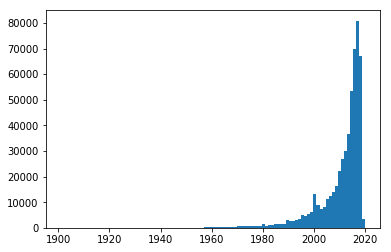

In [83]:
ax = plt.hist(df_dummy.dropna(subset=['ResidenceSince'])["ResidenceSince"], bins=100)

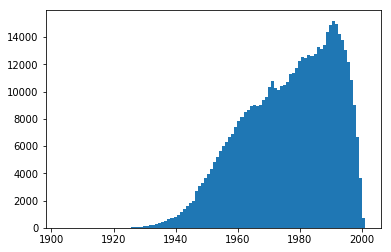

In [84]:
ax = plt.hist(df_dummy.dropna(subset=['DOB'])["DOB"], bins=100)

'DEPENDENTS', 'ResidenceSince', 'DOB' are highly skewed, knn imputation will used instead of direct imputation.

In [85]:
def knn_impute(df, col_name, sample_percentage=0.5, random_seed=0, n_neighbors=5, weights='distance'):
    from sklearn.neighbors import KNeighborsRegressor
    import math

    # Rearrange columns
    pred = df.drop(col_name, axis=1, inplace=False)
    pred.dropna(axis=1, how='any', thresh=None, subset=None, inplace=True)
    df_temp = pd.concat([df[col_name], pred], axis=1)
    df = pd.concat([df[col_name], df.drop(col_name, axis=1, inplace=False)], axis=1)
    
    # Create a dataframe that does not have nan for training
    df_without_nan = df_temp.loc[~pd.isnull(df_temp[col_name])].copy()
    df_without_nan[col_name] = pd.to_numeric(df_without_nan[col_name]).astype('float64')
    df_without_nan.dropna(axis=1, how='any', thresh=None, subset=None, inplace=True)
    df_without_nan = df_without_nan[[col for col in df_without_nan if df_without_nan[col].dtypes != 'datetime64[ns]']]
    df_without_nan = df_without_nan.sample(math.floor(len(df_without_nan)*sample_percentage), random_state=random_seed)
    
    # Create a dataframe for prediction
    df_with_nan = df_temp.loc[pd.isnull(df_temp[col_name])].copy()
    df_with_nan = df_with_nan.iloc[:,1:]
    df_with_nan.dropna(axis=1, how='any', thresh=None, subset=None, inplace=True)
    df_with_nan = df_with_nan[[col for col in df_with_nan if df_with_nan[col].dtypes != 'datetime64[ns]']]
    
    # Train k-Nearest Neighbor Classifier
    knnr = KNeighborsRegressor(n_neighbors, weights)
    trained_model = knnr.fit(df_without_nan.iloc[:, 1:], df_without_nan.iloc[:, 0])
    # Predict missing values
    imputed_values = trained_model.predict(df_with_nan)
    df_with_nan_imputed = pd.concat([pd.Series(imputed_values, name=col_name, index=df.loc[pd.isnull(df[col_name])].iloc[:,1:].index), df.loc[pd.isnull(df[col_name])].iloc[:,1:]], axis=1)
    
    # Final output
    temp = df.loc[~pd.isnull(df[col_name])]
    temp[col_name] = pd.to_numeric(temp[col_name]).astype('float64')
    df = pd.concat([temp, df_with_nan_imputed], axis=0)
    
    return df

In [86]:
df_dummy = knn_impute(df_dummy, 'DEPENDENTS')
df_dummy = knn_impute(df_dummy, 'ResidenceSince')
df_dummy = knn_impute(df_dummy, 'DOB')

In [87]:
df_treedummy = knn_impute(df_treedummy, 'DEPENDENTS')
df_treedummy = knn_impute(df_treedummy, 'ResidenceSince')
df_treedummy = knn_impute(df_treedummy, 'DOB')

In [88]:
df_dummy.isnull().sum().sort_values(ascending=False).head(5)

MARITAL_STATUS_3      0
PAY_CYCLE_M           0
ResidenceSince        0
DEPENDENTS            0
WriteOff_Indicator    0
dtype: int64

In [89]:
df_treedummy.isnull().sum().sort_values(ascending=False).head(5)

MARITAL_STATUS_3      0
PAY_CYCLE_M           0
ResidenceSince        0
DEPENDENTS            0
WriteOff_Indicator    0
dtype: int64

<a id = '1.4.2'></a>
#### 1.4.2 Nondimensionalization (preprocessing for non tree-based model)

In [90]:
df_dummy[[col_name for col_name in df_dummy if df_dummy[col_name].dtypes == 'float64']].describe()

,DOB,ResidenceSince,DEPENDENTS,RI_BALANCE
count,5.375040e+05,5.375040e+05,537504.000000,537504.000000
mean,2.089062e+17,1.282646e+18,0.000220,475.935610
std,4.633930e+17,2.935634e+17,0.023466,981.630035
min,-2.113171e+18,-2.177280e+18,0.000000,-1200.000000
25%,-1.316736e+17,1.208218e+18,0.000000,0.000000
50%,2.746656e+17,1.391040e+18,0.000000,0.000000
75%,5.996160e+17,1.470787e+18,0.000000,577.455000
max,9.828000e+17,1.575158e+18,6.000000,32678.070000


Standardscaler:
Assumes that data has normally distributed features and will scale them to zero mean and 1 standard deviation.
After applying the scaler all features will be of same scale .

Minmaxscaler :
This shrinks your data within the range of -1 to 1(if there are negative values).
This is used when distribution is not Guassian, responds well if standard deviation is small.
This scaler is sensitive to outliers.

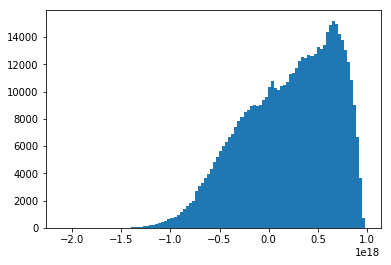

In [91]:
ax = plt.hist(df_dummy.dropna(subset=['DOB'])["DOB"], bins=100)

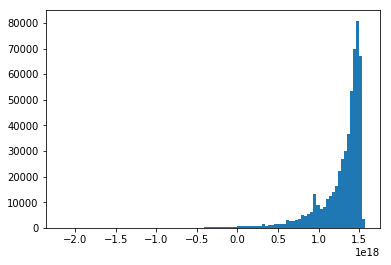

In [92]:
ax = plt.hist(df_dummy.dropna(subset=['ResidenceSince'])["ResidenceSince"], bins=100)

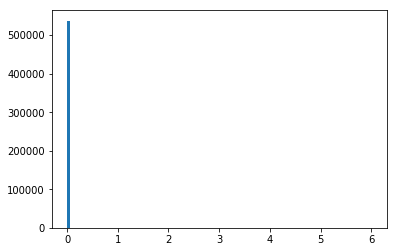

In [93]:
ax = plt.hist(df_dummy.dropna(subset=['DEPENDENTS'])["DEPENDENTS"], bins=100)

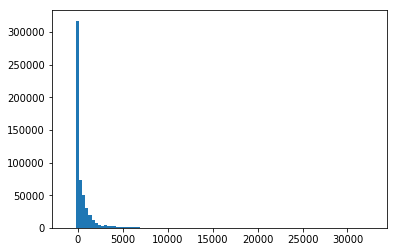

In [94]:
ax = plt.hist(df_dummy.dropna(subset=['RI_BALANCE'])["RI_BALANCE"], bins=100)

Since these distribution is not Guassian, MinMaxScaler will be used to scale the data:

In [95]:
# MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df_dummy[[col_name for col_name in df_dummy if df_dummy[col_name].dtypes == 'float64']])
df_dummy[[col_name for col_name in df_dummy if df_dummy[col_name].dtypes == 'float64']] = pd.DataFrame(np_scaled)

In [96]:
df_dummy[[col_name for col_name in df_dummy if df_dummy[col_name].dtypes == 'float64']].describe()

,DOB,ResidenceSince,DEPENDENTS,RI_BALANCE
count,537503.000000,537503.000000,537503.000000,537503.000000
mean,0.750032,0.922047,0.000037,0.049470
std,0.149676,0.078233,0.003911,0.028975
min,0.000000,0.000000,0.000000,0.000000
25%,0.640025,0.902213,0.000000,0.035421
50%,0.771272,0.950934,0.000000,0.035421
75%,0.876231,0.972186,0.000000,0.052466
max,1.000000,1.000000,1.000000,1.000000


In [97]:
# Check how much data is missing
df_dummy.isnull().sum().sort_values(ascending=False).head(5)

DOB               1
ResidenceSince    1
DEPENDENTS        1
RI_BALANCE        1
PAY_CYCLE_M       0
dtype: int64

In [98]:
# Remove NA after Nondimensionalization
df_dummy = df_dummy.dropna(subset=[col_name for col_name in df_dummy if df_dummy[col_name].dtypes == 'float64'])

In [99]:
# Check how much data is missing again
df_dummy.isnull().sum().sort_values(ascending=False).head(5)

MARITAL_STATUS_3      0
PAY_CYCLE_M           0
ResidenceSince        0
DEPENDENTS            0
WriteOff_Indicator    0
dtype: int64

<a id = '1.5'></a>
### 1.5 Feature engineering (for non tree-based model)

In [100]:
# Set target variable
y_dummy = df_dummy['WriteOff_Indicator']
y_treedummy = df_treedummy['WriteOff_Indicator']

# Set predictors
x_dummy = df_dummy.drop(['WriteOff_Indicator'], axis=1)
x_treedummy = df_treedummy.drop(['WriteOff_Indicator'], axis=1)

Create a self-defined function to generate interactions between numerical features and dummy variables

In [101]:
def add_interactions(df):
    from itertools import combinations
    from sklearn.preprocessing import PolynomialFeatures

    df_inter = []
    df_inter = pd.DataFrame(df_inter)
    categorical_column = [col_name for col_name in df if df[col_name].dtypes == 'uint8']
    numerical_column = [col_name for col_name in df if df[col_name].dtypes == 'float64']
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    for cat in categorical_column:
        for num in numerical_column:
            # Get feature names
            combos = list(combinations(list([cat, num]), 2))
            col = list([cat, num]) + ['*'.join(x) for x in combos]
            # Interaction
            df_temp = pd.DataFrame({cat: df[cat], num: df[num]})
            index_ = df_temp.index
            df_temp = poly.fit_transform(df_temp)
            df_temp = pd.DataFrame(df_temp, index=index_, columns=col)
            df_inter = pd.concat([df_inter, df_temp], axis=1)

    # Remove interaction terms with all 0 values            
    noint_indicies = [i for i, x in enumerate(list((df_inter == 0).all())) if x]
    df_inter = df_inter.drop(df_inter.columns[noint_indicies], axis=1)
    
    # Remove duplicated columns
    df_inter = df_inter.loc[:,~df_inter.columns.duplicated()]
    
    return df_inter

In [102]:
# Use PolynomialFeatures in sklearn.preprocessing to create two-way interactions for all features
def add_interactions_all(df):
    from itertools import combinations
    from sklearn.preprocessing import PolynomialFeatures
    
    # Get feature names
    combos = list(combinations(list(df.columns), 2))
    colnames = list(df.columns) + ['*'.join(x) for x in combos]
    
    # Find interactions
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames
    
    # Remove interaction terms with all 0 values            
    noint_indicies = [i for i, x in enumerate(list((df == 0).all())) if x]
    df = df.drop(df.columns[noint_indicies], axis=1)
    
    return df

In [103]:
x_dummy = add_interactions_all(x_dummy)
x_dummy.head()

,DOB,ResidenceSince,DEPENDENTS,RI_BALANCE,Is Internet_1,SPOUSE_DIR_DEP_1,GENDER_M,GENDER_other,BOUNCED_1,PAY_CYCLE_4,PAY_CYCLE_B,PAY_CYCLE_I,PAY_CYCLE_M,PAY_CYCLE_N,PAY_CYCLE_T,PAY_CYCLE_W,ACH_STATUS_S,OwnRentOther_1,OwnRentOther_2,OwnRentOther_3,ACCT_BLOCKED_1,COURTESY_CALL_NUM_C,COURTESY_CALL_NUM_H,ACTIVE_MILITARY_1,CC_BLOCK_1,MARITAL_STATUS_1,MARITAL_STATUS_2,MARITAL_STATUS_3,DOB*ResidenceSince,DOB*DEPENDENTS,DOB*RI_BALANCE,DOB*Is Internet_1,DOB*SPOUSE_DIR_DEP_1,DOB*GENDER_M,DOB*GENDER_other,DOB*BOUNCED_1,DOB*PAY_CYCLE_4,DOB*PAY_CYCLE_B,DOB*PAY_CYCLE_I,DOB*PAY_CYCLE_M,DOB*PAY_CYCLE_N,DOB*PAY_CYCLE_T,DOB*PAY_CYCLE_W,DOB*ACH_STATUS_S,DOB*OwnRentOther_1,DOB*OwnRentOther_2,DOB*OwnRentOther_3,DOB*ACCT_BLOCKED_1,DOB*COURTESY_CALL_NUM_C,DOB*COURTESY_CALL_NUM_H,DOB*ACTIVE_MILITARY_1,DOB*CC_BLOCK_1,DOB*MARITAL_STATUS_1,DOB*MARITAL_STATUS_2,DOB*MARITAL_STATUS_3,ResidenceSince*DEPENDENTS,ResidenceSince*RI_BALANCE,ResidenceSince*Is Internet_1,ResidenceSince*SPOUSE_DIR_DEP_1,ResidenceSince*GENDER_M,ResidenceSince*GENDER_other,ResidenceSince*BOUNCED_1,ResidenceSince*PAY_CYCLE_4,ResidenceSince*PAY_CYCLE_B,ResidenceSince*PAY_CYCLE_I,ResidenceSince*PAY_CYCLE_M,ResidenceSince*PAY_CYCLE_N,ResidenceSince*PAY_CYCLE_T,ResidenceSince*PAY_CYCLE_W,ResidenceSince*ACH_STATUS_S,ResidenceSince*OwnRentOther_1,ResidenceSince*OwnRentOther_2,ResidenceSince*OwnRentOther_3,ResidenceSince*ACCT_BLOCKED_1,ResidenceSince*COURTESY_CALL_NUM_C,ResidenceSince*COURTESY_CALL_NUM_H,ResidenceSince*ACTIVE_MILITARY_1,ResidenceSince*CC_BLOCK_1,ResidenceSince*MARITAL_STATUS_1,ResidenceSince*MARITAL_STATUS_2,ResidenceSince*MARITAL_STATUS_3,DEPENDENTS*RI_BALANCE,DEPENDENTS*Is Internet_1,DEPENDENTS*GENDER_M,DEPENDENTS*GENDER_other,DEPENDENTS*BOUNCED_1,DEPENDENTS*PAY_CYCLE_B,DEPENDENTS*PAY_CYCLE_I,DEPENDENTS*PAY_CYCLE_M,DEPENDENTS*PAY_CYCLE_T,DEPENDENTS*PAY_CYCLE_W,DEPENDENTS*OwnRentOther_1,DEPENDENTS*OwnRentOther_2,DEPENDENTS*OwnRentOther_3,DEPENDENTS*COURTESY_CALL_NUM_C,DEPENDENTS*COURTESY_CALL_NUM_H,DEPENDENTS*MARITAL_STATUS_1,RI_BALANCE*Is Internet_1,RI_BALANCE*SPOUSE_DIR_DEP_1,RI_BALANCE*GENDER_M,RI_BALANCE*GENDER_other,RI_BALANCE*BOUNCED_1,RI_BALANCE*PAY_CYCLE_4,RI_BALANCE*PAY_CYCLE_B,RI_BALANCE*PAY_CYCLE_I,RI_BALANCE*PAY_CYCLE_M,RI_BALANCE*PAY_CYCLE_N,RI_BALANCE*PAY_CYCLE_T,RI_BALANCE*PAY_CYCLE_W,RI_BALANCE*ACH_STATUS_S,RI_BALANCE*OwnRentOther_1,RI_BALANCE*OwnRentOther_2,RI_BALANCE*OwnRentOther_3,RI_BALANCE*ACCT_BLOCKED_1,RI_BALANCE*COURTESY_CALL_NUM_C,RI_BALANCE*COURTESY_CALL_NUM_H,RI_BALANCE*ACTIVE_MILITARY_1,RI_BALANCE*CC_BLOCK_1,RI_BALANCE*MARITAL_STATUS_1,RI_BALANCE*MARITAL_STATUS_2,RI_BALANCE*MARITAL_STATUS_3,Is Internet_1*SPOUSE_DIR_DEP_1,Is Internet_1*GENDER_M,Is Internet_1*GENDER_other,Is Internet_1*BOUNCED_1,Is Internet_1*PAY_CYCLE_4,Is Internet_1*PAY_CYCLE_B,Is Internet_1*PAY_CYCLE_I,Is Internet_1*PAY_CYCLE_M,Is Internet_1*PAY_CYCLE_N,Is Internet_1*PAY_CYCLE_T,Is Internet_1*PAY_CYCLE_W,Is Internet_1*ACH_STATUS_S,Is Internet_1*OwnRentOther_1,Is Internet_1*OwnRentOther_2,Is Internet_1*OwnRentOther_3,Is Internet_1*ACCT_BLOCKED_1,Is Internet_1*COURTESY_CALL_NUM_C,Is Internet_1*COURTESY_CALL_NUM_H,Is Internet_1*ACTIVE_MILITARY_1,Is Internet_1*CC_BLOCK_1,Is Internet_1*MARITAL_STATUS_1,Is Internet_1*MARITAL_STATUS_2,Is Internet_1*MARITAL_STATUS_3,SPOUSE_DIR_DEP_1*GENDER_other,SPOUSE_DIR_DEP_1*BOUNCED_1,SPOUSE_DIR_DEP_1*PAY_CYCLE_B,SPOUSE_DIR_DEP_1*PAY_CYCLE_M,SPOUSE_DIR_DEP_1*PAY_CYCLE_T,SPOUSE_DIR_DEP_1*PAY_CYCLE_W,SPOUSE_DIR_DEP_1*OwnRentOther_1,SPOUSE_DIR_DEP_1*OwnRentOther_2,SPOUSE_DIR_DEP_1*OwnRentOther_3,SPOUSE_DIR_DEP_1*COURTESY_CALL_NUM_C,SPOUSE_DIR_DEP_1*COURTESY_CALL_NUM_H,SPOUSE_DIR_DEP_1*MARITAL_STATUS_1,GENDER_M*BOUNCED_1,GENDER_M*PAY_CYCLE_4,GENDER_M*PAY_CYCLE_B,GENDER_M*PAY_CYCLE_I,GENDER_M*PAY_CYCLE_M,GENDER_M*PAY_CYCLE_N,GENDER_M*PAY_CYCLE_T,GENDER_M*PAY_CYCLE_W,GENDER_M*ACH_STATUS_S,GENDER_M*OwnRentOther_1,GENDER_M*OwnRentOther_2,GENDER_M*OwnRentOther_3,GENDER_M*ACCT_BLOCKED_1,GENDER_M*COURTESY_CALL_NUM_C,GENDER_M*COURTESY_CALL_NUM_H,GENDER_M*CC_BLO

In [104]:
x_dummy.shape

(537503, 330)

<a id = '1.6'></a>
### 1.6 Target balancing

In [105]:
df_dummy['WriteOff_Indicator'].value_counts().head()

0    527136
1     10367
Name: WriteOff_Indicator, dtype: int64

In [106]:
df_treedummy['WriteOff_Indicator'].value_counts().head()

0    527137
1     10367
Name: WriteOff_Indicator, dtype: int64

In [107]:
# Train-Test Split
from sklearn.model_selection import train_test_split

x_dummy_train, x_dummy_test, y_dummy_train, y_dummy_test = train_test_split(x_dummy, y_dummy, test_size=0.3, random_state=0)
x_treedummy_train, x_treedummy_test, y_treedummy_train, y_treedummy_test = train_test_split(x_treedummy, y_treedummy, test_size=0.3, random_state=0)

<a id = '1.6.1'></a>
#### 1.6.1 SMOTE

In [108]:
# Define a function to create a scatter plot of our data and labels
import matplotlib.pyplot as plt   
%matplotlib inline

def plot_data(x,  y, x_col_index, y_col_index):
    plt.scatter(x[y == 0, x_col_index], x[y == 0, y_col_index], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(x[y == 1, x_col_index], x[y == 1, y_col_index], label="Class #1", alpha=0.5, linewidth=0.15, c='y')
    plt.legend()
    return plt.show()

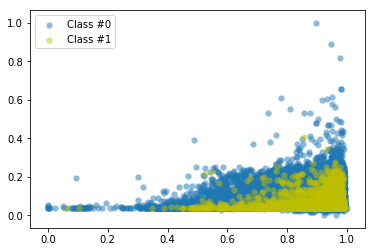

In [109]:
plot_data(x_dummy_train.values, y_dummy_train.values, x_col_index=1, y_col_index=3)

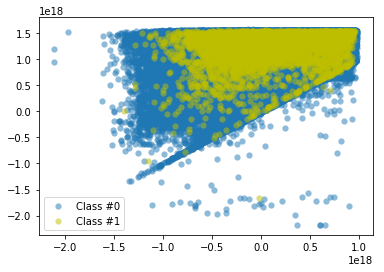

In [110]:
plot_data(x_treedummy_train.values, y_treedummy_train.values, x_col_index=0, y_col_index=1)

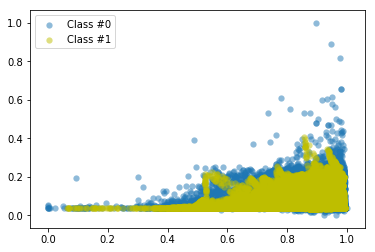

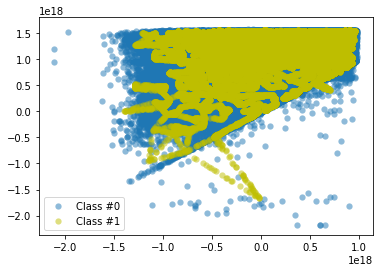

In [111]:
from imblearn.over_sampling import SMOTE

# Define the resampling method
method = SMOTE(kind='regular', sampling_strategy='all', k_neighbors=3)

# Create the resampled feature set
x_resampled, y_resampled = method.fit_sample(x_dummy_train, y_dummy_train)
x_dummy_train_SMOTE = pd.DataFrame(x_resampled, columns=x_dummy_train.columns)
y_dummy_train_SMOTE = pd.Series(y_resampled, name=y_dummy_train.name)

x_resampled, y_resampled = method.fit_sample(x_treedummy_train, y_treedummy_train)
x_treedummy_train_SMOTE = pd.DataFrame(x_resampled, columns=x_treedummy_train.columns)
y_treedummy_train_SMOTE = pd.Series(y_resampled, name=y_treedummy_train.name)

# Plot the resampled data
plot_data(x_dummy_train_SMOTE.values, y_dummy_train_SMOTE.values, x_col_index=1, y_col_index=3)
plot_data(x_treedummy_train_SMOTE.values, y_treedummy_train_SMOTE.values, x_col_index=0, y_col_index=1)

<a id = '1.6.2'></a>
#### 1.6.2 Self-defined undersampling & oversampling

In [112]:
def upsampling_downsamling(up_sampling_coef, dn_sampling_coef, dataframe, target, rand_seed):
    # Upsampling minority category: 1s & downsampling majority category: 0s

    df_joint_class0 = dataframe[dataframe[target] == 0]
    df_joint_class1 = dataframe[dataframe[target] == 1]
 
    df_joint_class0_dnsampled = df_joint_class0.sample(frac=dn_sampling_coef, replace = False, random_state = rand_seed)
    df_joint_class1_upsampled = df_joint_class1.sample(frac=up_sampling_coef, replace = True, random_state = rand_seed)
    frames = [df_joint_class0_dnsampled, df_joint_class1_upsampled]
    df_joint = pd.concat(frames)   
    
    return df_joint

In [113]:
x_dummy_train = x_dummy_train_SMOTE
y_dummy_train = y_dummy_train_SMOTE
x_treedummy_train = x_treedummy_train_SMOTE
y_treedummy_train = y_treedummy_train_SMOTE

<a id = '1.7'></a>
### 1.7 Dimensionality reduction

For dimensionality reduction, Filter (Pearson and Chi-Squared, and Mutual Information), Wrapper (RFE), and Embedded (LightGBM) methods are all used to rank the features. A vote is conducted on 5 ranking results to obtain the final comprehensive ranking results.

<a id = '1.7.1'></a>
#### 1.7.1 Filter

Define a Pearson selector:

In [114]:
def cor_selector(x, y, num_features):
    feature_name = x.columns.tolist()
    cor_list = []
    # Calculate the correlation with y for each feature
    for i in x.columns.tolist():
        cor = np.corrcoef(x[i], y)[0, 1]
        cor_list.append(cor)
    # Replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # Feature name
    cor_feature = x.iloc[:,np.argsort(np.abs(cor_list))[-num_features:]].columns.tolist()
    cor_support = [True if i in cor_feature else False for i in feature_name]
    print(str(len(cor_feature)), 'features selected by Pearson')
    print('------------------------------------------------------------------------------') 
    return cor_support

Define a Chi-Squared selector:

In [115]:
def chi_selector(x, y, num_features):
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import chi2

    chi_selector = SelectKBest(chi2, num_features)
    chi_selector.fit(x, y)
    chi_support = chi_selector.get_support()
    chi_feature = x.loc[:,chi_support].columns.tolist()
    print(str(len(chi_feature)), 'features selected by Chi-Squared')
    print('------------------------------------------------------------------------------') 
    return chi_support

Define a Mutual Information selector:

In [116]:
def mutual_info_selector(x, y, num_features):
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import mutual_info_classif

    info_selector = SelectKBest(mutual_info_classif, num_features)
    info_selector.fit(x, y)
    info_support = info_selector.get_support()
    info_feature = x.loc[:,info_support].columns.tolist()
    print(str(len(info_feature)), 'features selected by Mutual Information')
    print('------------------------------------------------------------------------------') 
    return info_support

<a id = '1.7.2'></a>
#### 1.7.2 Wrapper

Define a RFE (logistic) selector:

In [117]:
def rfe_logistic_selector(x, y, num_features):
    from sklearn.feature_selection import RFE
    from sklearn.linear_model import LogisticRegression
    
    rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_features, step=10, verbose=5)
    rfe_selector.fit(x, y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = x.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'features selected by RFE Logistic')
    print('------------------------------------------------------------------------------') 
    return rfe_support

<a id = '1.7.3'></a>
#### 1.7.3 Embedded

Define a LGBM selector:

In [118]:
def lgbc_selector(x, y):
    from sklearn.feature_selection import SelectFromModel
    from lightgbm import LGBMClassifier

    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2, reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
    embeded_lgb_selector = SelectFromModel(lgbc, threshold='1.25*median')
    embeded_lgb_selector.fit(x, y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = x.loc[:,embeded_lgb_support].columns.tolist()
    print(str(len(embeded_lgb_feature)), 'features selected by LGBM')
    print('------------------------------------------------------------------------------') 
    return embeded_lgb_support    

<a id = '1.7.4'></a>
#### 1.7.4 Feature selection voter

In [119]:
def feature_selection_voting(x, y, num_features=60, threshold=4):
    cor_support = cor_selector(x, y, num_features)
    chi_support = chi_selector(x, y, num_features)
    info_support = mutual_info_selector(x, y, num_features)
    rfe_support = rfe_logistic_selector(x, y, num_features)
    embeded_lgb_support = lgbc_selector(x, y)
    feature_selection_df = pd.DataFrame({'Feature':x.columns.tolist(), 
                                         'Pearson':cor_support, 
                                         'Chi-2':chi_support, 
                                         'Mutual Information':info_support,
                                         'RFE (Logistic)':rfe_support, 
                                         'LightGBM':embeded_lgb_support})
    # Count the selected times for each feature
    feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
    # Display
    feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
    feature_selection_df.index = range(1, len(feature_selection_df)+1)
    return feature_selection_df.loc[feature_selection_df['Total'] >= threshold]

Voting results:

In [120]:
colnames_selected = feature_selection_voting(x_dummy_train, y_dummy_train, num_features=70, threshold=4)
colnames_selected

70 features selected by Pearson
------------------------------------------------------------------------------
70 features selected by Chi-Squared
------------------------------------------------------------------------------
70 features selected by Mutual Information
------------------------------------------------------------------------------
Fitting estimator with 330 features.
Fitting estimator with 320 features.
Fitting estimator with 310 features.
Fitting estimator with 300 features.
Fitting estimator with 290 features.
Fitting estimator with 280 features.
Fitting estimator with 270 features.
Fitting estimator with 260 features.
Fitting estimator with 250 features.
Fitting estimator with 240 features.
Fitting estimator with 230 features.
Fitting estimator with 220 features.
Fitting estimator with 210 features.
Fitting estimator with 200 features.
Fitting estimator with 190 features.
Fitting estimator with 180 features.
Fitting estimator with 170 features.
Fitting estimator with 

,Feature,Pearson,Chi-2,Mutual Information,RFE (Logistic),LightGBM,Total
1,ResidenceSince*BOUNCED_1,True,True,True,True,True,5
2,PAY_CYCLE_M,True,True,True,True,True,5
3,OwnRentOther_2*COURTESY_CALL_NUM_C,True,True,True,True,True,5
4,Is Internet_1*MARITAL_STATUS_1,True,True,True,True,True,5
5,Is Internet_1*GENDER_other,True,True,True,True,True,5
6,Is Internet_1*BOUNCED_1,True,True,True,True,True,5
7,BOUNCED_1*PAY_CYCLE_W,True,True,True,True,True,5
8,BOUNCED_1*PAY_CYCLE_B,True,True,True,True,True,5
9,BOUNCED_1*MARITAL_STATUS_1,True,True,True,True,True,5
10,ResidenceSince*PAY_CYCLE_W,True,True,True,False,True,4


Select columns:

In [121]:
colnames_selected = colnames_selected['Feature']
x_dummy_train_selected = x_dummy_train[colnames_selected]
x_dummy_test_selected = x_dummy_test[colnames_selected]

<a id = 'Step2'></a>
## Step 2: Model Building

For the loan default prediction, false negative rates (a borrower will default a loan, but the
prediction is the opposite) will be used to evaluate the model, along with accuracy, AUC under ROC, and f1 score.

<a id = '2.1'></a>
### 2.1 Functions

<a id = '2.1.1'></a>
#### 2.1.1 Define a function for FPR and FNR

In [122]:
# Create a performance measurement function for TP, FP, TN, FN
# Inputs are pd df

def perf_measure_pd(y_actual, y_hat):
    TP = 0; FP = 0; TN = 0; FN = 0
    # Count TP, FP, TN, FN
    for i in range(len(y_hat)): 
        if y_actual.iloc[i] == y_hat[i] == 1:
            TP += 1
        if y_hat[i] == 1 and y_actual.iloc[i] != y_hat[i]:
            FP += 1
        if y_actual.iloc[i] == y_hat[i] == 0:
            TN += 1
        if y_hat[i] == 0 and y_actual.iloc[i] != y_hat[i]:
            FN += 1
    # Sensitivity, hit rate, recall, or true positive rate
    #TPR = TP/(TP+FN)
    # Specificity or true negative rate
    #TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    #PPV = TP/(TP+FP)
    # Negative predictive value
    #NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    #FDR = FP/(TP+FP)
    # Accuracy
    ACC = (TP+TN)/(TP+TN+FP+FN)
    return FPR, FNR, ACC

In [123]:
# Create a performance measurement function for TP, FP, TN, FN
# Inputs are np array

def perf_measure_np(y_actual, y_hat):
    TP = 0; FP = 0; TN = 0; FN = 0
    # Count TP, FP, TN, FN
    for i in range(len(y_hat)): 
        if y_actual[i] == y_hat[i] == 1:
            TP += 1
        if y_hat[i] == 1 and y_actual[i] != y_hat[i]:
            FP += 1
        if y_actual[i] == y_hat[i] == 0:
            TN += 1
        if y_hat[i] == 0 and y_actual[i] != y_hat[i]:
            FN += 1
    # Sensitivity, hit rate, recall, or true positive rate
    #TPR = TP/(TP+FN)
    # Specificity or true negative rate
    #TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    #PPV = TP/(TP+FP)
    # Negative predictive value
    #NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    #FDR = FP/(TP+FP)
    # Accuracy
    ACC = (TP+TN)/(TP+TN+FP+FN)
    return FPR, FNR, ACC

<a id = '2.1.2'></a>
#### 2.1.2 Define a function for ROC

In [124]:
def roc_plot(y, y_pred, title='Receiver Operating Characteristic'):
    import numpy as np
    from scipy import interp
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    from sklearn.model_selection import StratifiedKFold
    
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.8,
                label='ROC (AUC = %0.4f)' % (roc_auc))

    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black',
         label='Random Guess', alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

<a id = '2.1.3'></a>
#### 2.1.3 Define a function for ROC (CROSS VALIDATION)

In [125]:
def roc_cv_plot(classifier, x, y, n_splits):
    import numpy as np
    from scipy import interp
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    from sklearn.model_selection import StratifiedKFold
    
    cv = StratifiedKFold(n_splits)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 1
    for train, test in cv.split(x, y):
        probas_ = classifier.fit(x.values[train], y.values[train]).predict_proba(x.values[test])
        fpr, tpr, thresholds = roc_curve(y.values[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.4f)' % (i, roc_auc))
        i += 1
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black',
             label='Random Guess', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
             lw=1, alpha=.5)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - 2*std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 2 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (CROSS VALIDATION)')
    plt.legend(loc="lower right")
    plt.show()
    return mean_auc

<a id = '2.1.4'></a>
#### 2.1.4 Define a function for AUC under ROC (CROSS VALIDATION)

In [126]:
def roc_cv_value(classifier, x, y, n_splits):
    import numpy as np
    from scipy import interp
    from sklearn.metrics import roc_curve, auc
    from sklearn.model_selection import StratifiedKFold
    
    cv = StratifiedKFold(n_splits)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 1
    for train, test in cv.split(x, y):
        probas_ = classifier.fit(x.values[train], y.values[train]).predict_proba(x.values[test])
        fpr, tpr, thresholds = roc_curve(y.values[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        i += 1

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    return mean_auc

<a id = '2.1.5'></a>
#### 2.1.5 Define a function for FPR, FNR (CROSS VALIDATION)

In [127]:
def perf_measure_cv_value(classifier, x, y, n_splits, threshold):
    import numpy as np
    from scipy import interp
    from sklearn.metrics import roc_curve, auc
    from sklearn.model_selection import StratifiedKFold
    
    cv = StratifiedKFold(n_splits)
    fprs = []
    fnrs = []
    accs = []

    i = 1
    for train, test in cv.split(x, y):
        probas_ = classifier.fit(x.values[train], y.values[train]).predict_proba(x.values[test])[:, 1]
        y_hat = [1 if x >= threshold else 0 for x in probas_]
        fpr, fnr, acc = perf_measure_np(y.values[test], y_hat)
        fprs.append(fpr)
        fnrs.append(fnr)
        accs.append(acc)
        i += 1

    mean_fpr = np.mean(fprs)
    mean_fnr = np.mean(fnrs)
    mean_acc = np.mean(accs)    

    return mean_fpr, mean_fnr, mean_acc

<a id = '2.1.6'></a>
#### 2.1.6 Define a function for overall model performance

In [128]:
# Create a function that measures model performance
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
    
def cls_performance(classifier, x_train, y_train, y_pred_train, y_pred_proba_train, x_test, y_test, y_pred_test, y_pred_proba_test, n_splits=5):
    # Overall estimate
    # Compute train ROC AUC
    roc_auc_train = roc_auc_score(y_train, y_pred_proba_train)
    print('Train ROC AUC: {:.6f}'.format(roc_auc_train))
    
    # Compute the n-folds CV ROC AUC
    roc_auc_cv_train = roc_cv_value(classifier, x_train, y_train, n_splits)
    print('Train CV ROC AUC: {:.6f}'.format(roc_auc_cv_train))
    
    # Compute test ROC AUC
    roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)
    print('Test ROC AUC: {:.6f}'.format(roc_auc_test)) 
    
    # Plot train ROC
    roc_plot(y_train, y_pred_proba_train, title='Receiver Operating Characteristic (TRAIN)')
    
    # Plot the 10-folds CV ROC
    roc_cv_plot(classifier, x_train, y_train, n_splits)

    # Plot test ROC
    roc_plot(y_test, y_pred_proba_test, title='Receiver Operating Characteristic (TEST)')
    
    # Point Estimate
    fp_train_list = []
    fn_train_list = []
    acc_train_list = []
    
    fp_cv_train_list = []
    fn_cv_train_list = []
    acc_cv_train_list = []
    
    fp_test_list = []
    fn_test_list = []
    acc_test_list = []
    
    thresh_list = []
    
    print('------------------------------------------------------------------------------')        
    
    print('Trying to search for a threshold to MINIMIZE point Type I + Type II Error...')
    for thresh in np.arange(0.4, 0.7, 0.01):
        y_pred_train_thresh = [1 if x >= thresh else 0 for x in y_pred_proba_train]
        y_pred_train_thresh = np.asarray(y_pred_train_thresh)
        y_pred_test_thresh = [1 if x >= thresh else 0 for x in y_pred_proba_test]
        y_pred_test_thresh = np.asarray(y_pred_test_thresh)
        
        # Compute train false negative rate (Type II error)
        fp_train, fn_train, acc_train = perf_measure_pd(y_train, y_pred_train_thresh)

        # Compute the 10-folds CV false negative rate (Type II error)
        # cross_val_score does not have the false negative rate scoring, the value will be taken to be 0 for simplicity
        fp_cv_train, fn_cv_train, acc_cv_train = perf_measure_cv_value(classifier, x_train, y_train, n_splits, threshold=thresh)

        # Compute test false negative rate (Type II error)
        fp_test, fn_test, acc_test = perf_measure_pd(y_test, y_pred_test_thresh)
        
        if fp_test > 0.4 or fn_test > 0.4:
            pass
        else:
            fp_train_list.append(fp_train)
            fn_train_list.append(fn_train)
            acc_train_list.append(acc_train)

            fp_cv_train_list.append(fp_cv_train)
            fn_cv_train_list.append(fn_cv_train)
            acc_cv_train_list.append(acc_cv_train)

            fp_test_list.append(fp_test)
            fn_test_list.append(fn_test)
            acc_test_list.append(acc_test)

            thresh_list.append(thresh)
        
    lists = [thresh_list, fp_train_list, fn_train_list, acc_train_list, fp_cv_train_list, fn_cv_train_list, acc_cv_train_list, fp_test_list, fn_test_list, acc_test_list]
    thresh_info = np.array(lists)
    thresh_info = np.transpose(thresh_info)
    thresh_info = pd.DataFrame(thresh_info, columns=['thresh_list', 
                                                     'fp_train_list', 
                                                     'fn_train_list', 
                                                     'acc_train_list', 
                                                     'fp_cv_train_list', 
                                                     'fn_cv_train_list', 
                                                     'acc_cv_train_list', 
                                                     'fp_test_list', 
                                                     'fn_test_list', 
                                                     'acc_test_list'])
    #thresh_max = thresh_info.loc[thresh_info['acc_test_list'] == max(thresh_info['acc_test_list'])]
    thresh_max = thresh_info
    thresh_max['Type I + Tpye II'] = thresh_max['fp_test_list'] + thresh_max['fn_test_list']
    try:
        thresh_max = thresh_info.loc[thresh_info['Type I + Tpye II'] == min(thresh_info['Type I + Tpye II'])]
        print('Minimum point Type I + Type II Error reached')
        print('------------------------------------------------------------------------------')    
        print('When the cutoff probability is {:.2f}: '.format(thresh_max['thresh_list'].to_list()[0]))
        print('')
        print('Train False Negative Rate (Type II error): {:.6f}'.format(thresh_max['fn_train_list'].to_list()[0]))
        print('Train CV False Negative Rate (Type II error): {:.6f}'.format(thresh_max['fn_cv_train_list'].to_list()[0]))
        print('Test False Negative Rate (Type II error): {:.6f}'.format(thresh_max['fn_test_list'].to_list()[0]))
        print('Train False Positive Rate (Type I error): {:.6f}'.format(thresh_max['fp_train_list'].to_list()[0]))
        print('Train CV False Positive Rate (Type I error): {:.6f}'.format(thresh_max['fp_cv_train_list'].to_list()[0]))
        print('Test False Positive Rate (Type I error): {:.6f}'.format(thresh_max['fp_test_list'].to_list()[0]))
        #print('Train Accuracy: {:.6f}'.format(thresh_max['acc_train_list'].to_list()[0]))
        #print('Train CV Accuracy: {:.6f}'.format(thresh_max['acc_cv_train_list'].to_list()[0]))
        #print('Test Accuracy: {:.6f}'.format(thresh_max['acc_test_list'].to_list()[0]))      

        print('------------------------------------------------------------------------------') 
        y_pred_train_thresh = [1 if x >= thresh_max['thresh_list'].to_list()[0] else 0 for x in y_pred_proba_train]
        y_pred_train_thresh = np.asarray(y_pred_train_thresh)
        y_pred_test_thresh = [1 if x >= thresh_max['thresh_list'].to_list()[0] else 0 for x in y_pred_proba_test]
        y_pred_test_thresh = np.asarray(y_pred_test_thresh)

        print('When the cutoff probability is {:.2f}: '.format(thresh_max['thresh_list'].to_list()[0]))
        print('')
        print('Train Confusion Matrix:')
        confusion_train = pd.crosstab(y_train, y_pred_train_thresh, rownames=['Actual'], colnames=['Predicted'], margins=True)
        print(confusion_train)
        print('')
        print('Test Confusion Matrix:')
        confusion_test = pd.crosstab(y_test, y_pred_test_thresh, rownames=['Actual'], colnames=['Predicted'], margins=True)
        print(confusion_test)
    except:
        y_pred_train_thresh = [1 if x >= 0.5 else 0 for x in y_pred_proba_train]
        y_pred_train_thresh = np.asarray(y_pred_train_thresh)
        y_pred_test_thresh = [1 if x >= 0.5 else 0 for x in y_pred_proba_test]
        y_pred_test_thresh = np.asarray(y_pred_test_thresh)
        
        # Compute train false negative rate (Type II error)
        fp_train, fn_train, acc_train = perf_measure_pd(y_train, y_pred_train_thresh)

        # Compute the 10-folds CV false negative rate (Type II error)
        # cross_val_score does not have the false negative rate scoring, the value will be taken to be 0 for simplicity
        fp_cv_train, fn_cv_train, acc_cv_train = perf_measure_cv_value(classifier, x_train, y_train, n_splits, threshold=0.5)

        # Compute test false negative rate (Type II error)
        fp_test, fn_test, acc_test = perf_measure_pd(y_test, y_pred_test_thresh)
        
        fp_train_list.append(fp_train)
        fn_train_list.append(fn_train)
        acc_train_list.append(acc_train)

        fp_cv_train_list.append(fp_cv_train)
        fn_cv_train_list.append(fn_cv_train)
        acc_cv_train_list.append(acc_cv_train)

        fp_test_list.append(fp_test)
        fn_test_list.append(fn_test)
        acc_test_list.append(acc_test)

        thresh_list.append(thresh)
        
        lists = [thresh_list, fp_train_list, fn_train_list, acc_train_list, fp_cv_train_list, fn_cv_train_list, acc_cv_train_list, fp_test_list, fn_test_list, acc_test_list]
        thresh_info = np.array(lists)
        thresh_info = np.transpose(thresh_info)
        thresh_info = pd.DataFrame(thresh_info, columns=['thresh_list', 
                                                         'fp_train_list', 
                                                         'fn_train_list', 
                                                         'acc_train_list', 
                                                         'fp_cv_train_list', 
                                                         'fn_cv_train_list', 
                                                         'acc_cv_train_list', 
                                                         'fp_test_list', 
                                                         'fn_test_list', 
                                                         'acc_test_list'])
        thresh_max = thresh_info
        thresh_max['Type I + Tpye II'] = thresh_max['fp_test_list'] + thresh_max['fn_test_list']
    
        print('Minimum point Type I + Type II Error not reached, default threshold (0.5) will be used')
        print('------------------------------------------------------------------------------')    
        print('When the cutoff probability is {:.2f}: '.format(0.5))
        print('')
        print('Train False Negative Rate (Type II error): {:.6f}'.format(thresh_max['fn_train_list'].to_list()[0]))
        print('Train CV False Negative Rate (Type II error): {:.6f}'.format(thresh_max['fn_cv_train_list'].to_list()[0]))
        print('Test False Negative Rate (Type II error): {:.6f}'.format(thresh_max['fn_test_list'].to_list()[0]))
        print('Train False Positive Rate (Type I error): {:.6f}'.format(thresh_max['fp_train_list'].to_list()[0]))
        print('Train CV False Positive Rate (Type I error): {:.6f}'.format(thresh_max['fp_cv_train_list'].to_list()[0]))
        print('Test False Positive Rate (Type I error): {:.6f}'.format(thresh_max['fp_test_list'].to_list()[0]))
        #print('Train Accuracy: {:.6f}'.format(thresh_max['acc_train_list'].to_list()[0]))
        #print('Train CV Accuracy: {:.6f}'.format(thresh_max['acc_cv_train_list'].to_list()[0]))
        #print('Test Accuracy: {:.6f}'.format(thresh_max['acc_test_list'].to_list()[0]))      

        print('------------------------------------------------------------------------------') 
        y_pred_train_thresh = [1 if x >= thresh_max['thresh_list'].to_list()[0] else 0 for x in y_pred_proba_train]
        y_pred_train_thresh = np.asarray(y_pred_train_thresh)
        y_pred_test_thresh = [1 if x >= thresh_max['thresh_list'].to_list()[0] else 0 for x in y_pred_proba_test]
        y_pred_test_thresh = np.asarray(y_pred_test_thresh)

        print('When the cutoff probability is {:.2f}: '.format(0.5))
        print('')
        print('Train Confusion Matrix:')
        confusion_train = pd.crosstab(y_train, y_pred_train_thresh, rownames=['Actual'], colnames=['Predicted'], margins=True)
        print(confusion_train)
        print('')
        print('Test Confusion Matrix:')
        confusion_test = pd.crosstab(y_test, y_pred_test_thresh, rownames=['Actual'], colnames=['Predicted'], margins=True)
        print(confusion_test)
    
    return roc_auc_train, roc_auc_cv_train, roc_auc_test, thresh_max['fp_train_list'].to_list()[0], thresh_max['fp_cv_train_list'].to_list()[0], thresh_max['fp_test_list'].to_list()[0], thresh_max['fn_train_list'].to_list()[0], thresh_max['fn_cv_train_list'].to_list()[0], thresh_max['fn_test_list'].to_list()[0]

<a id = '2.2'></a>
### 2.2 Modeling fitting

<a id = '2.2.1'></a>
#### 2.2.1 Logistic regression

In [129]:
from sklearn.linear_model import LogisticRegression

x_train = x_dummy_train_selected
y_train = y_dummy_train
x_test = x_dummy_test_selected
y_test= y_dummy_test

init_time = time.time()
logr = LogisticRegression()
logr.fit(x_train, y_train)

y_pred_train = logr.predict(x_train)
y_pred_test = logr.predict(x_test)

y_pred_proba_train = logr.predict_proba(x_train)[:,1]
y_pred_proba_test = logr.predict_proba(x_test)[:,1]

Train ROC AUC: 0.729250
Train CV ROC AUC: 0.729089
Test ROC AUC: 0.725644


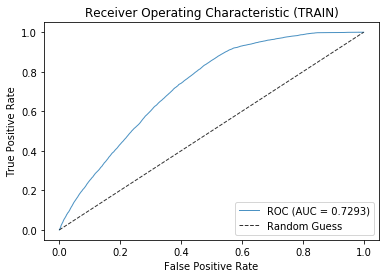

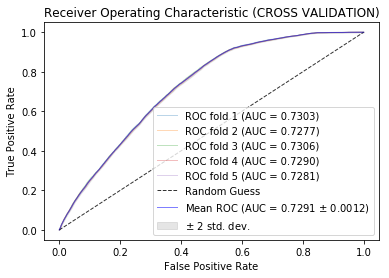

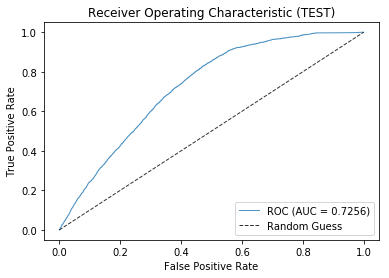

------------------------------------------------------------------------------
Trying to search for a threshold to MINIMIZE point Type I + Type II Error...
Minimum point Type I + Type II Error reached
------------------------------------------------------------------------------
When the cutoff probability is 0.55: 

Train False Negative Rate (Type II error): 0.273433
Train CV False Negative Rate (Type II error): 0.272853
Test False Negative Rate (Type II error): 0.274711
Train False Positive Rate (Type I error): 0.387048
Train CV False Positive Rate (Type I error): 0.387281
Test False Positive Rate (Type I error): 0.387346
------------------------------------------------------------------------------
When the cutoff probability is 0.55: 

Train Confusion Matrix:
Predicted       0       1     All
Actual                           
0          226180  142821  369001
1          100897  268104  369001
All        327077  410925  738002

Test Confusion Matrix:
Predicted      0      1     All


In [130]:
roc_auc_train, roc_auc_cv_train, roc_auc_test, fp_train, fp_cv_train, fp_test, fn_train, fn_cv_train, fn_test = cls_performance(logr,
x_train, y_train, y_pred_train, y_pred_proba_train, x_test, y_test, y_pred_test, y_pred_proba_test)

In [131]:
time_dur = time.time() - init_time
print('Processed time: {} seconds'.format(time_dur))

Processed time: 2520.3511004447937 seconds


In [132]:
logr_performance = [time_dur, roc_auc_train, roc_auc_cv_train, roc_auc_test, fp_train, fp_cv_train, fp_test, fn_train, fn_cv_train, fn_test]

<a id = '2.2.2'></a>
#### 2.2.2 SVM

Caution: VERY SLOW!

In [133]:
# from sklearn.svm import SVC

# x_train = x_dummy_train_selected
# y_train = y_dummy_train
# x_test = x_dummy_test_selected
# y_test= y_dummy_test

# init_time = time.time()
# svm = SVC(probability=True)
# svm.fit(x_train, y_train)

# y_pred_train = svm.predict(x_train)
# y_pred_test = svm.predict(x_test)

# y_pred_proba_train = svm.predict_proba(x_train)[:,1]
# y_pred_proba_test = svm.predict_proba(x_test)[:,1]

# time_dur = time.time() - init_time
# print('Processed time: {} seconds'.format(time_dur))

In [134]:
# roc_auc_train, roc_auc_cv_train, roc_auc_test, fp_train, fp_cv_train, fp_test, fn_train, fn_cv_train, fn_test = cls_performance(svm,
# x_train, y_train, y_pred_train, y_pred_proba_train, x_test, y_test, y_pred_test, y_pred_proba_test)
# svm_performance = [time_dur, roc_auc_train, roc_auc_cv_train, roc_auc_test, fp_train, fp_cv_train, fp_test, fn_train, fn_cv_train, fn_test]

<a id = '2.2.3'></a>
#### 2.2.3 Decision tree

In [135]:
from sklearn.tree import DecisionTreeClassifier

init_time = time.time()
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(x_train, y_train)

y_pred_train = dt.predict(x_train)
y_pred_test = dt.predict(x_test)

y_pred_proba_train = dt.predict_proba(x_train)[:,1]
y_pred_proba_test = dt.predict_proba(x_test)[:,1]

Train ROC AUC: 0.674380
Train CV ROC AUC: 0.674360
Test ROC AUC: 0.674794


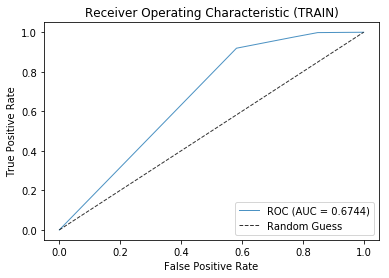

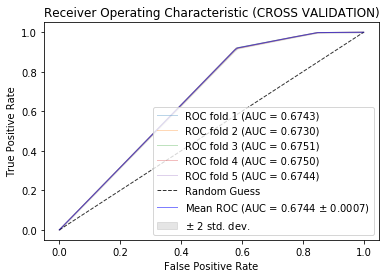

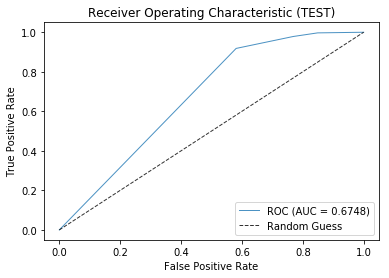

------------------------------------------------------------------------------
Trying to search for a threshold to MINIMIZE point Type I + Type II Error...
Minimum point Type I + Type II Error not reached, default threshold (0.5) will be used
------------------------------------------------------------------------------
When the cutoff probability is 0.50: 

Train False Negative Rate (Type II error): 0.080731
Train CV False Negative Rate (Type II error): 0.080734
Test False Negative Rate (Type II error): 0.081836
Train False Positive Rate (Type I error): 0.582139
Train CV False Positive Rate (Type I error): 0.582145
Test False Positive Rate (Type I error): 0.581010
------------------------------------------------------------------------------
When the cutoff probability is 0.50: 

Train Confusion Matrix:
Predicted       0     All
Actual                   
0          369001  369001
1          369001  369001
All        738002  738002

Test Confusion Matrix:
Predicted       0     All
Actu

In [136]:
roc_auc_train, roc_auc_cv_train, roc_auc_test, fp_train, fp_cv_train, fp_test, fn_train, fn_cv_train, fn_test = cls_performance(dt,
x_train, y_train, y_pred_train, y_pred_proba_train, x_test, y_test, y_pred_test, y_pred_proba_test)

In [137]:
time_dur = time.time() - init_time
print('Processed time: {} seconds'.format(time_dur))

Processed time: 1429.768273115158 seconds


In [138]:
dt_performance = [time_dur, roc_auc_train, roc_auc_cv_train, roc_auc_test, fp_train, fp_cv_train, fp_test, fn_train, fn_cv_train, fn_test]

<a id = '2.2.4'></a>
#### 2.2.4 Random forest

In [139]:
from sklearn.ensemble import RandomForestClassifier

init_time = time.time()
rf = RandomForestClassifier(max_depth=2,
                            n_estimators=20,
                            max_features=10)
rf.fit(x_train, y_train)

y_pred_train = rf.predict(x_train)
y_pred_test = rf.predict(x_test)

y_pred_proba_train = rf.predict_proba(x_train)[:,1]
y_pred_proba_test = rf.predict_proba(x_test)[:,1]

Train ROC AUC: 0.713809
Train CV ROC AUC: 0.719288
Test ROC AUC: 0.698221


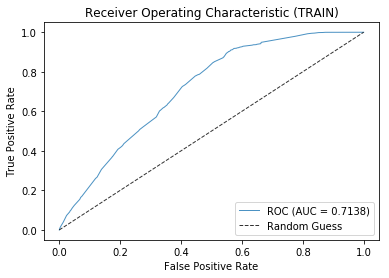

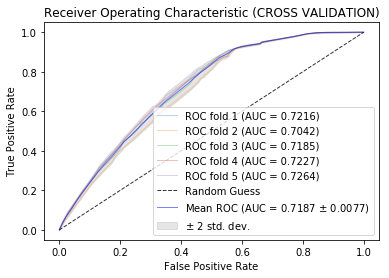

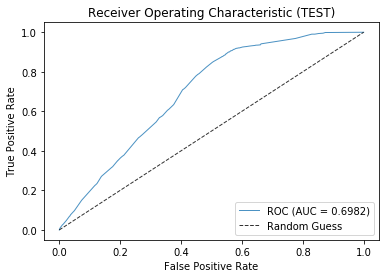

------------------------------------------------------------------------------
Trying to search for a threshold to MINIMIZE point Type I + Type II Error...
Minimum point Type I + Type II Error not reached, default threshold (0.5) will be used
------------------------------------------------------------------------------
When the cutoff probability is 0.50: 

Train False Negative Rate (Type II error): 0.080734
Train CV False Negative Rate (Type II error): 0.075257
Test False Negative Rate (Type II error): 0.082157
Train False Positive Rate (Type I error): 0.581581
Train CV False Positive Rate (Type I error): 0.595670
Test False Positive Rate (Type I error): 0.580523
------------------------------------------------------------------------------
When the cutoff probability is 0.50: 

Train Confusion Matrix:
Predicted       0     All
Actual                   
0          369001  369001
1          369001  369001
All        738002  738002

Test Confusion Matrix:
Predicted       0     All
Actu

In [140]:
roc_auc_train, roc_auc_cv_train, roc_auc_test, fp_train, fp_cv_train, fp_test, fn_train, fn_cv_train, fn_test = cls_performance(rf,
x_train, y_train, y_pred_train, y_pred_proba_train, x_test, y_test, y_pred_test, y_pred_proba_test)

In [141]:
time_dur = time.time() - init_time
print('Processed time: {} seconds'.format(time_dur))

Processed time: 2109.6090812683105 seconds


In [142]:
rf_performance = [time_dur, roc_auc_train, roc_auc_cv_train, roc_auc_test, fp_train, fp_cv_train, fp_test, fn_train, fn_cv_train, fn_test]

<a id = '2.2.5'></a>
#### 2.2.5 Bootstrap aggregating

In [143]:
from sklearn.ensemble import BaggingClassifier

x_train = x_dummy_train_selected
y_train = y_dummy_train
x_test = x_dummy_test_selected
y_test= y_dummy_test

init_time = time.time()
bc = BaggingClassifier(base_estimator=logr)
bc.fit(x_train, y_train)

y_pred_train = bc.predict(x_train)
y_pred_test = bc.predict(x_test)

y_pred_proba_train = bc.predict_proba(x_train)[:,1]
y_pred_proba_test = bc.predict_proba(x_test)[:,1]

Train ROC AUC: 0.729319
Train CV ROC AUC: 0.729108
Test ROC AUC: 0.725551


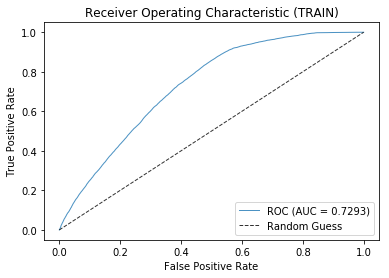

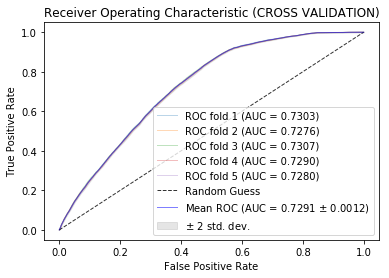

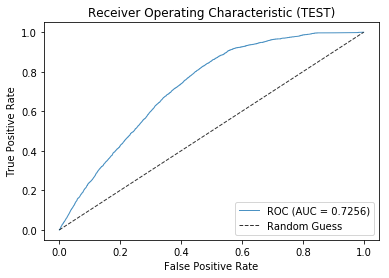

------------------------------------------------------------------------------
Trying to search for a threshold to MINIMIZE point Type I + Type II Error...
Minimum point Type I + Type II Error reached
------------------------------------------------------------------------------
When the cutoff probability is 0.55: 

Train False Negative Rate (Type II error): 0.271333
Train CV False Negative Rate (Type II error): 0.273595
Test False Negative Rate (Type II error): 0.275032
Train False Positive Rate (Type I error): 0.387855
Train CV False Positive Rate (Type I error): 0.387037
Test False Positive Rate (Type I error): 0.388036
------------------------------------------------------------------------------
When the cutoff probability is 0.55: 

Train Confusion Matrix:
Predicted       0       1     All
Actual                           
0          225882  143119  369001
1          100122  268879  369001
All        326004  411998  738002

Test Confusion Matrix:
Predicted      0      1     All


In [144]:
roc_auc_train, roc_auc_cv_train, roc_auc_test, fp_train, fp_cv_train, fp_test, fn_train, fn_cv_train, fn_test = cls_performance(bc,
x_train, y_train, y_pred_train, y_pred_proba_train, x_test, y_test, y_pred_test, y_pred_proba_test)

In [145]:
time_dur = time.time() - init_time
print('Processed time: {} seconds'.format(time_dur))

Processed time: 15103.254162788391 seconds


In [146]:
bc_performance = [time_dur, roc_auc_train, roc_auc_cv_train, roc_auc_test, fp_train, fp_cv_train, fp_test, fn_train, fn_cv_train, fn_test]

<a id = '2.2.6'></a>
#### 2.2.6 Gradient boosting

In [147]:
from sklearn.ensemble import GradientBoostingClassifier

x_train = x_dummy_train_selected
y_train = y_dummy_train
x_test = x_dummy_test_selected
y_test= y_dummy_test

init_time = time.time()
gc = GradientBoostingClassifier(loss='deviance',
                                learning_rate=0.06, 
                                n_estimators=20, 
                                max_depth=2,
                                min_samples_leaf=200)
gc.fit(x_train, y_train)

y_pred_train = gc.predict(x_train)
y_pred_test = gc.predict(x_test)

y_pred_proba_train = gc.predict_proba(x_train)[:,1]
y_pred_proba_test = gc.predict_proba(x_test)[:,1]

Train ROC AUC: 0.723204
Train CV ROC AUC: 0.722782
Test ROC AUC: 0.675439


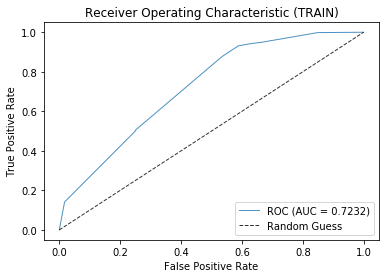

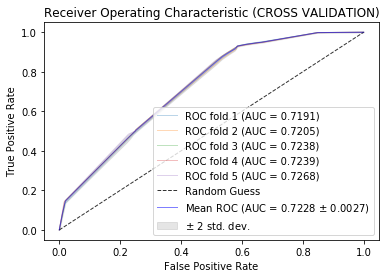

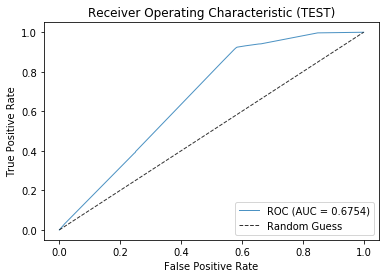

------------------------------------------------------------------------------
Trying to search for a threshold to MINIMIZE point Type I + Type II Error...
Minimum point Type I + Type II Error not reached, default threshold (0.5) will be used
------------------------------------------------------------------------------
When the cutoff probability is 0.50: 

Train False Negative Rate (Type II error): 0.074040
Train CV False Negative Rate (Type II error): 0.074046
Test False Negative Rate (Type II error): 0.077022
Train False Positive Rate (Type I error): 0.583302
Train CV False Positive Rate (Type I error): 0.583313
Test False Positive Rate (Type I error): 0.582167
------------------------------------------------------------------------------
When the cutoff probability is 0.50: 

Train Confusion Matrix:
Predicted       0     All
Actual                   
0          369001  369001
1          369001  369001
All        738002  738002

Test Confusion Matrix:
Predicted       0     All
Actu

In [148]:
roc_auc_train, roc_auc_cv_train, roc_auc_test, fp_train, fp_cv_train, fp_test, fn_train, fn_cv_train, fn_test = cls_performance(gc,
x_train, y_train, y_pred_train, y_pred_proba_train, x_test, y_test, y_pred_test, y_pred_proba_test)

In [149]:
time_dur = time.time() - init_time
print('Processed time: {} seconds'.format(time_dur))

Processed time: 3863.825809955597 seconds


In [150]:
gc_performance = [time_dur, roc_auc_train, roc_auc_cv_train, roc_auc_test, fp_train, fp_cv_train, fp_test, fn_train, fn_cv_train, fn_test]

<a id = '2.2.7'></a>
#### 2.2.7 XGBoost

In [151]:
from xgboost import XGBClassifier

x_train = x_dummy_train_selected
y_train = y_dummy_train
x_test = x_dummy_test_selected
y_test= y_dummy_test

init_time = time.time()
xgbc = XGBClassifier(max_depth=2,
                     learning_rate=0.06,
                     n_estimators=20,
                     )
xgbc.fit(x_train, y_train)

y_pred_train = xgbc.predict(x_train)
y_pred_test = xgbc.predict(x_test)

y_pred_proba_train = xgbc.predict_proba(x_train)[:,1]
y_pred_proba_test = xgbc.predict_proba(x_test)[:,1]

Train ROC AUC: 0.705924
Train CV ROC AUC: 0.705909
Test ROC AUC: 0.673417


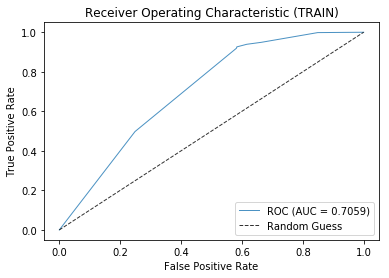

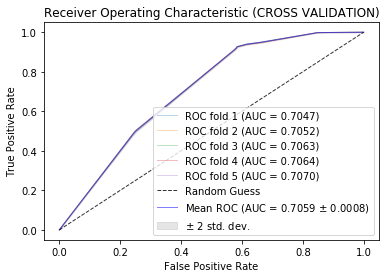

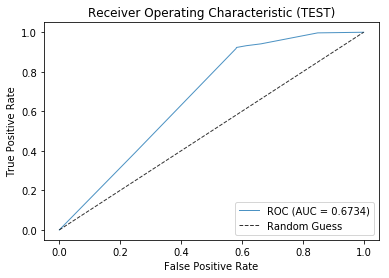

------------------------------------------------------------------------------
Trying to search for a threshold to MINIMIZE point Type I + Type II Error...
Minimum point Type I + Type II Error not reached, default threshold (0.5) will be used
------------------------------------------------------------------------------
When the cutoff probability is 0.50: 

Train False Negative Rate (Type II error): 0.080731
Train CV False Negative Rate (Type II error): 0.080734
Test False Negative Rate (Type II error): 0.081836
Train False Positive Rate (Type I error): 0.582134
Train CV False Positive Rate (Type I error): 0.582145
Test False Positive Rate (Type I error): 0.581010
------------------------------------------------------------------------------
When the cutoff probability is 0.50: 

Train Confusion Matrix:
Predicted       0     All
Actual                   
0          369001  369001
1          369001  369001
All        738002  738002

Test Confusion Matrix:
Predicted       0     All
Actu

In [152]:
roc_auc_train, roc_auc_cv_train, roc_auc_test, fp_train, fp_cv_train, fp_test, fn_train, fn_cv_train, fn_test = cls_performance(xgbc,
x_train, y_train, y_pred_train, y_pred_proba_train, x_test, y_test, y_pred_test, y_pred_proba_test)

In [153]:
time_dur = time.time() - init_time
print('Processed time: {} seconds'.format(time_dur))

Processed time: 3370.986433982849 seconds


In [154]:
xgbc_performance = [time_dur, roc_auc_train, roc_auc_cv_train, roc_auc_test, fp_train, fp_cv_train, fp_test, fn_train, fn_cv_train, fn_test]

<a id = 'Step3'></a>
## Step 3: Model Comparison

In [155]:
# Append model performance results
perf = pd.DataFrame({'Logistic Regression': logr_performance,
                     #'SVM': svm_performance, (VERY SLOW)
                     'Decision Tree': dt_performance,
                     'Random Forest': rf_performance,
                     'Bootstrap Aggregating': bc_performance,
                     'Gradient Boosting': gc_performance,
                     'XGBoost': xgbc_performance})
perf.rename(index={0:'Processed Time',
                   1:'Train ROC AUC', 2:'Train CV ROC AUC', 3:'Test ROC AUC',
                   4:'Train fpr', 5:'Train CV fpr', 6:'Test fpr',
                   7:'Train fnr', 8:'Train CV fnr', 9:'Test fnr'}, inplace=True)
perf = perf.transpose()
perf

,Processed Time,Train ROC AUC,Train CV ROC AUC,Test ROC AUC,Train fpr,Train CV fpr,Test fpr,Train fnr,Train CV fnr,Test fnr
Logistic Regression,2520.351100,0.729250,0.729089,0.725644,0.387048,0.387281,0.387346,0.273433,0.272853,0.274711
Decision Tree,1429.768273,0.674380,0.674360,0.674794,0.582139,0.582145,0.581010,0.080731,0.080734,0.081836
Random Forest,2109.609081,0.713809,0.719288,0.698221,0.581581,0.595670,0.580523,0.080734,0.075257,0.082157
Bootstrap Aggregating,15103.254163,0.729319,0.729108,0.725551,0.387855,0.387037,0.388036,0.271333,0.273595,0.275032
Gradient Boosting,3863.825810,0.723204,0.722782,0.675439,0.583302,0.583313,0.582167,0.074040,0.074046,0.077022
XGBoost,3370.986434,0.705924,0.705909,0.673417,0.582134,0.582145,0.581010,0.080731,0.080734,0.081836


<a id = '3.1'></a>
### 3.1 Performance measures

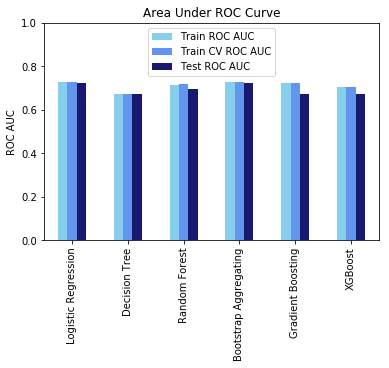

In [161]:
ax = perf.iloc[:, 1:4].plot.bar(color=["skyblue", "cornflowerblue", "midnightblue"])
ax = plt.ylim(0, 1)
ax = plt.title('Area Under ROC Curve')
ax = plt.legend(loc='upper center')
ax = plt.ylabel("ROC AUC")

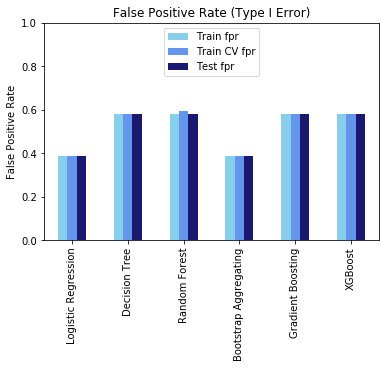

In [162]:
ax = perf.iloc[:, 4:7].plot.bar(color=["skyblue", "cornflowerblue", "midnightblue"])
ax = plt.ylim(0, 1) 
ax = plt.title('False Positive Rate (Type I Error)')
ax = plt.legend(loc='upper center')
ax = plt.ylabel("False Positive Rate") 

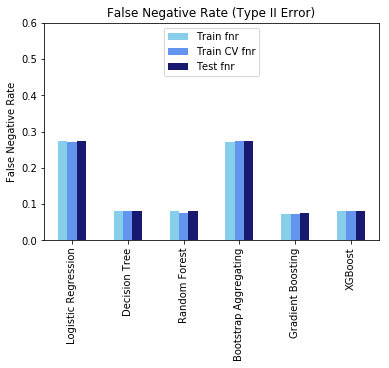

In [163]:
ax = perf.iloc[:, 7:].plot.bar(color=["skyblue", "cornflowerblue", "midnightblue"])
ax = plt.ylim(0, 0.6) 
ax = plt.title('False Negative Rate (Type II Error)')
ax = plt.legend(loc='upper center')
ax = plt.ylabel("False Negative Rate") 

<a id = '3.2'></a>
### 3.2 Time complexity

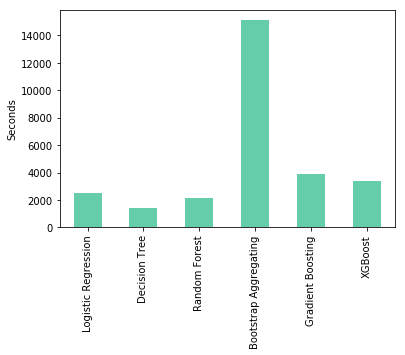

In [164]:
ax = perf.iloc[:, 0].plot.bar(color=["mediumaquamarine"])
ax = plt.ylabel("Seconds") 

In [160]:
print('Total processed time: {} minutes'.format((time.time() - start_time)/60))

Total processed time: 549.890863998731 minutes
